# AdventureGame Evaluation
This notebook produces tables and plots to analyse AdventureGame results. All plots and tables appearing in the AdventureGame paper are created using the contained code.

In [1124]:
import sys
# sys.path.append('..')

from pathlib import Path

import json
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Polygon
from numpy.ma.extras import average

import evaluation.evalutils as utils
from evaluation.makingtables import build_dispersion_table
import evaluation.clemmetrics as clemmetrics

Choose path for the .csv with the raw scores. This is created after running ```bencheval.py```.

In [1125]:
RAW_PATH = Path('results/raw.csv')
raw_df = pd.read_csv(RAW_PATH, index_col=0)

Full results dataframe:

In [1126]:
raw_df

,game,model,experiment,episode,metric,value
0,adventuregame,claude-3-7-sonnet-20250219-t0.0--claude-3-7-so...,0_home_deliver_three_basic_easy,episode_0,Violated Request Count,0.0
1,adventuregame,claude-3-7-sonnet-20250219-t0.0--claude-3-7-so...,0_home_deliver_three_basic_easy,episode_0,Parsed Request Count,10.0
2,adventuregame,claude-3-7-sonnet-20250219-t0.0--claude-3-7-so...,0_home_deliver_three_basic_easy,episode_0,Request Count,10.0
3,adventuregame,claude-3-7-sonnet-20250219-t0.0--claude-3-7-so...,0_home_deliver_three_basic_easy,episode_0,Request Success Ratio,1.0
4,adventuregame,claude-3-7-sonnet-20250219-t0.0--claude-3-7-so...,0_home_deliver_three_basic_easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
69127,adventuregame,Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder...,7_home_deliver_three_basic_preexplore_hard,episode_5,Played,1.0
69128,adventuregame,Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder...,7_home_deliver_three_basic_preexplore_hard,episode_6,Played,0.0
69129,adventuregame,Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder...,7_home_deliver_three_basic_preexplore_hard,episode_7,Played,0.0
69130,adventuregame,Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder...,7_home_deliver_three_basic_preexplore_hard,episode_8,Played,0.0


Dictionaries for converting full model, experiment and score/metric names to compact names:

In [1127]:
model_name_dict = {
    # 'gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF-q5-t0.0': "gemma-2-9b-it-q5",
    # 'gemma-7b-it-Groq-t0.0--gemma-7b-it-Groq-t0.0': "gemma-7b-it",
    # 'gemma2-9b-it-Groq-t0.0--gemma2-9b-it-Groq-t0.0': "gemma2-9b-it",
    # 'Llama-3-70B-Instruct-Groq-t0.0--Llama-3-70B-Instruct-Groq-t0.0': "Llama-3-70B-Instruct",
    # 'Llama-3-8B-Instruct-Groq-t0.0--Llama-3-8B-Instruct-Groq-t0.0': "Llama-3-8B-Instruct",
    # 'llama-3.1-70b-versatile-Groq-t0.0--llama-3.1-70b-versatile-Groq-t0.0': "Llama-3.1-70b-Instruct",
    # 'llama-3.1-8b-instant-Groq-t0.0--llama-3.1-8b-instant-Groq-t0.0': "Llama-3.1-8b-Instruct",
    # 'LLaMA2-13B-Tiefighter-t0.0--LLaMA2-13B-Tiefighter-t0.0': "LLaMA2-13B-Tiefighter",
    # 'Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0--Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0': "Llama-3.1-405B-Instruct",
    # 'Mistral-Large-Instruct-2407-t0.0--Mistral-Large-Instruct-2407-t0.0': "Mistral-Large-Instruct-2407",
    # 'openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q5-t0.0': "openchat3.5-GGUF-q5",
    'openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0': 'openchat3.5-Q8',
    'openchat_3.5-t0.0--openchat_3.5-t0.0': "openchat3.5",
    # 'Qwen1.5-72B-Chat-t0.0--Qwen1.5-72B-Chat-t0.0': "Qwen1.5-72B-Chat",
    'Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0': "Qwen2-72B",
    'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0': 'Llama-3.1-8B',
    'Meta-Llama-3-8B-Instruct-t0.0--Meta-Llama-3-8B-Instruct-t0.0': 'Llama-3-8B',
    'Qwen2.5-7B-Instruct-t0.0--Qwen2.5-7B-Instruct-t0.0': 'Qwen2.5-7B',
    'Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0': 'Qwen2.5-32B',
    'Qwen2.5-Coder-7B-Instruct-t0.0--Qwen2.5-Coder-7B-Instruct-t0.0': 'Qwen2.5C-7B',
    'Qwen2.5-72B-Instruct-t0.0--Qwen2.5-72B-Instruct-t0.0': 'Qwen2.5-72B',
    'Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0': 'Llama-3.3-70B',
    'Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0': 'Llama-3.1-70B',
    'Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0': 'Sky-T1-32B',
    'llama-3.1-405b-t0.0--llama-3.1-405b-t0.0': 'Llama-3.1-405B',
    'gpt-4o-2024-08-06-t0.0--gpt-4o-2024-08-06-t0.0': 'GPT-4o',
    'claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0': 'Claude-3.5',
    'claude-3-7-sonnet-20250219-t0.0--claude-3-7-sonnet-20250219-t0.0': 'Claude-3.7',
    'qwen-max-t0.0--qwen-max-t0.0': 'Qwen-max',
    'gemini-2.0-flash-exp-t0.0--gemini-2.0-flash-exp-t0.0': 'Gemini-2.0',
    'deepseek-v3-t0.0--deepseek-v3-t0.0': 'DeepSeek-V3',
    'o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0': 'o3-mini',
    'human-t0.0--human-t0.0': 'human'
}

top_models = [
    'o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0',
    # 'claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0',
    'claude-3-7-sonnet-20250219-t0.0--claude-3-7-sonnet-20250219-t0.0',
    'gpt-4o-2024-08-06-t0.0--gpt-4o-2024-08-06-t0.0',
    'Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0',
    'Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0',
    'Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0',
    'Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0',
    'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0',
    'Qwen2.5-72B-Instruct-t0.0--Qwen2.5-72B-Instruct-t0.0'
    ]

final_models = [
    'claude-3-7-sonnet-20250219-t0.0--claude-3-7-sonnet-20250219-t0.0',
    'o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0',
    'gpt-4o-2024-08-06-t0.0--gpt-4o-2024-08-06-t0.0',
    'Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0',
    'Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0',
    'deepseek-v3-t0.0--deepseek-v3-t0.0',
    'Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0',
    'Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0',
    'Qwen2.5-72B-Instruct-t0.0--Qwen2.5-72B-Instruct-t0.0',
    'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0'
]

final_models_human = [
    'claude-3-7-sonnet-20250219-t0.0--claude-3-7-sonnet-20250219-t0.0',
    'o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0',
    'gpt-4o-2024-08-06-t0.0--gpt-4o-2024-08-06-t0.0',
    'Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0',
    'Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0',
    'deepseek-v3-t0.0--deepseek-v3-t0.0',
    'Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0',
    'Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0',
    'Qwen2.5-72B-Instruct-t0.0--Qwen2.5-72B-Instruct-t0.0',
    'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0',
    'human-t0.0--human-t0.0'
]

experiment_short_name_dict = {
    '0_home_deliver_three_basic_easy': "basic-easy",
    '1_home_deliver_three_basic_preexplore_easy': "basic-easy-preexp",
    '4_home_deliver_three_basic_easy_invlimittwo': "basic-easy-invlimit",
    '6_home_deliver_three_basic_hard': "basic-hard",
    '7_home_deliver_three_basic_preexplore_hard': "basic-hard-preexp",
    '10_home_deliver_three_basic_hard_invlimittwo': "basic-hard-invlimit",
    '12_new-words_home-delivery_easy_basic_easy': "new-words-easy",
    '13_new-words_home-delivery_medium_basic_medium': "new-words-medium",
    '14_new-words_created_basic_hard': "new-words-hard",
    '15_potion_brewing_basic_undefined': "potion-brewing",
}

metric_name_dict = {
    'taking_from_inventory': "taking from inventory",
    'other_room_argument': "interacting with other room",
    'not_room_type': "going to non-existent room",
    'going_to_current_room': "going to current room",
    'no_exit_to': "going to non-adjacent room",
    'multiple_exits_to': "ambiguous traversal",
    'entity_already_inventory': "entity already in inventory",
    'thing_arg1_room': "first entity is room",
    'entity_not_accessible': "entity not accessible",
    'multiple_entity_ambiguity': "ambiguous entity",
    'thing_arg2_room': "second entity is room",
    'pre_state_mismatch': "main condition not fact",
    'action_parsing_fail': "parsing failure",
    'action_resolution_fail': "resolution failure",
    'lark_exception': "out of grammar",
    'malformed_command': "malformed command",
    'undefined_action_verb': "undefined action verb",
    'undefined_action': "undefined action type",
    'undefined_repr_str': "undefined noun",
    'manipulating_room': "manipulating room",
    'undefined_argument_type': "undefined antecedent",
    'successful_actions': "successful actions",
    'finish_speed': "finish speed",
    'domain_trait_type_mismatch': "domain mismatch",
    'domain_type_discrepancy': "domain discrepancy",
    'world_state_discrepancy': "world state discrepancy",
    'entity_state_mismatch': "entity state mismatch",
    'entity_trait_mismatch': "entity trait mismatch",
    'inventory_limit_exceeded': "inventory limit exceeded"
}

Dataframe containing only AdventureGame results (needed in case AdventureGame was run along with other clemgames), with short model and experiment names:

In [1128]:
game_df = raw_df[raw_df.game == 'adventuregame']
game_df = game_df.replace(model_name_dict).replace(experiment_short_name_dict)
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Claude-3.7,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Claude-3.7,basic-easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Claude-3.7,basic-easy,episode_0,Request Count,10.0
3,adventuregame,Claude-3.7,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Claude-3.7,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
69127,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_5,Played,1.0
69128,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_6,Played,0.0
69129,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_7,Played,0.0
69130,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_8,Played,0.0


## Overall benchmark scores

In [1129]:
# read the clem scores
RESULTS_PATH = Path('results/results.csv')
clem_df = pd.read_csv(RESULTS_PATH, index_col=0)

Full overall score dataframe (useful in case other clemgames were run along with AdventureGame):

In [1130]:
clem_df = clem_df.rename(model_name_dict)
clem_df = clem_df.drop('human')
clem_df

,"-, clemscore","adventuregame, % Played","adventuregame, Quality Score","adventuregame, Quality Score (std)","all, Average % Played","all, Average Quality Score"
Claude-3.7,97.78,100.00,97.78,14.91,100.00,97.78
DeepSeek-V3,40.20,82.22,48.89,50.55,82.22,48.89
GPT-4o,51.36,88.89,57.78,49.95,88.89,57.78
Llama-3.1-70B,50.96,95.56,53.33,50.45,95.56,53.33
Llama-3.1-8B,11.26,42.22,26.67,44.72,42.22,26.67
Llama-3.3-70B,45.63,93.33,48.89,50.55,93.33,48.89
Qwen2-72B,26.27,62.22,42.22,49.95,62.22,42.22
Qwen2.5-32B,14.22,53.33,26.67,44.72,53.33,26.67
Qwen2.5-72B,17.28,55.56,31.11,46.82,55.56,31.11
o3-mini,73.18,86.67,84.44,36.65,86.67,84.44


Overview dataframe, omitting averages for 'all games' (assumes only AdventureGame results present):

In [1131]:
overview_df = clem_df.rename(model_name_dict).drop(columns=["all, Average % Played", "all, Average Quality Score", "adventuregame, Quality Score (std)"]).sort_values(by='-, clemscore', ascending=False)
overview_short_columns = {"-, clemscore": "clemscore", "adventuregame, % Played": "% Played", "adventuregame, Quality Score": "Quality Score", "adventuregame, Quality Score (std)": "Quality Score (std)"}
overview_df = overview_df.rename(columns=overview_short_columns)
overview_df

,clemscore,% Played,Quality Score
Claude-3.7,97.78,100.00,97.78
o3-mini,73.18,86.67,84.44
GPT-4o,51.36,88.89,57.78
Llama-3.1-70B,50.96,95.56,53.33
Llama-3.3-70B,45.63,93.33,48.89
DeepSeek-V3,40.20,82.22,48.89
Qwen2-72B,26.27,62.22,42.22
Qwen2.5-72B,17.28,55.56,31.11
Qwen2.5-32B,14.22,53.33,26.67
Llama-3.1-8B,11.26,42.22,26.67


In [1132]:
# get overall goal%:
goals_df = game_df.drop(columns=["game"])
# goals_df = goals_df.query('metric in ["Main Score", "Played", "achieved_goal_rating"]')
goals_df = goals_df.query('metric in ["achieved_goal_rating"]')

# goals_df = goals_df.query("model in ['o3-mini', 'Claude-3.5', 'Llama-3.1-70B', 'Qwen2.5-32B', 'GPT-4o']")

# goals_df = build_dispersion_table(['model', 'experiment', 'metric'], goals_df)
goals_df = build_dispersion_table(['model', 'metric'], goals_df)
# goals_df = build_dispersion_table(['model'], goals_df)

goals_df = goals_df.drop(columns=["var", "median", "max", "min", "skew", "std"])

goals_df = goals_df.rename({"achieved_goal_rating": "% Goals"})

goals_df = pd.pivot_table(goals_df, index=['model'], columns='metric')

# goals_df = goals_df.rename({'mean': '% Goals'})

goals_df[('metric', '% Goals')] = goals_df[('mean', '% Goals')]

goals_df = goals_df.drop(columns=[('mean', '% Goals')])

goals_df

,metric
metric,% Goals
model,
Claude-3.7,82.708333
DeepSeek-V3,58.333333
GPT-4o,68.333333
Llama-3.1-70B,60.416667
Llama-3.1-8B,28.958333
Llama-3.3-70B,57.083333
Qwen2-72B,42.916667
Qwen2.5-32B,40.208333


In [1133]:
# combined_df = pd.concat([overview_df, goals_col.rename("% Goals")], axis=1)
# combined_df = pd.concat([overview_df, goals_col], axis=1)
combined_df = pd.concat([overview_df, goals_df], axis=1)
combined_df = combined_df.rename({'mean': '% Goals'})
combined_df

,clemscore,% Played,Quality Score,"(metric, % Goals)"
Claude-3.7,97.78,100.00,97.78,82.708333
o3-mini,73.18,86.67,84.44,78.541667
GPT-4o,51.36,88.89,57.78,68.333333
Llama-3.1-70B,50.96,95.56,53.33,60.416667
Llama-3.3-70B,45.63,93.33,48.89,57.083333
DeepSeek-V3,40.20,82.22,48.89,58.333333
Qwen2-72B,26.27,62.22,42.22,42.916667
Qwen2.5-72B,17.28,55.56,31.11,35.625000
Qwen2.5-32B,14.22,53.33,26.67,40.208333
Llama-3.1-8B,11.26,42.22,26.67,28.958333


In [1134]:
combined_df.to_html("results/adventuregame_overview_table_goals.html")

In [1135]:
combined_overview_styled = combined_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
# ], overwrite=False).format(subset="clemscore", precision=1).format(subset="% Played", precision=1).format(subset="Quality Score", precision=1).format(subset="('metric', '% Goals')", precision=1)
], overwrite=False).format(precision=1)
combined_overview_styled.to_latex('results/adventuregame_overview_table_goals.tex')

In [1136]:
overview_df.to_html("results/adventuregame_overview_table.html")
overview_df.to_csv("results/adventuregame_overview_table.csv")

In [1137]:
overview_styled = overview_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="clemscore", precision=1).format(subset="% Played", precision=1).format(subset="Quality Score", precision=1)
overview_styled.to_latex('results/adventuregame_overview_table.tex')

Model comparison stacked bar plot:

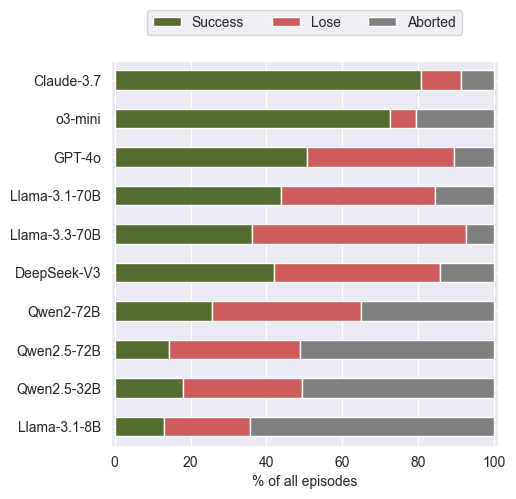

In [1138]:
STACK_COLORS = ['darkolivegreen', 'indianred', 'gray']

df_aux = raw_df[raw_df.metric.isin(utils.GAMEPLAY_METRICS)]

df_aux = df_aux.replace(model_name_dict)

df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of all episodes')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/episode_overview_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

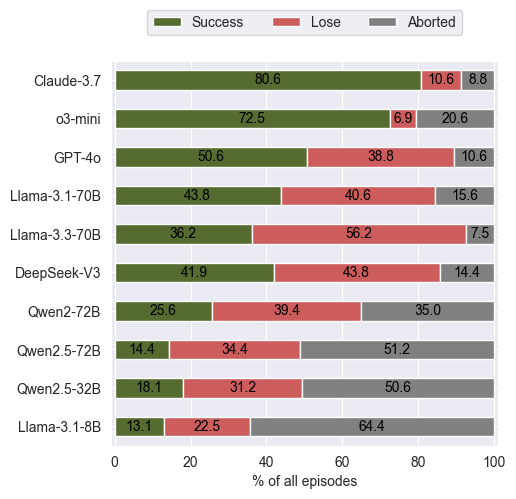

In [1139]:
STACK_COLORS = ['darkolivegreen', 'indianred', 'gray']

df_aux = raw_df[raw_df.metric.isin(utils.GAMEPLAY_METRICS)]

df_aux = df_aux.replace(model_name_dict)

df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.sort_values(by='-, clemscore').index
percs = percs.reindex(order)

stacks = percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))

# print(stacks.__dict__)
# plt.bar_label(stacks, label_type='center')
# stacks.bar_label(percs)
for bar in stacks.containers:
    labels = [np.round(v.get_width(), 1) for v in bar]
    # labels = [v for v in bar]
    # for v in bar:
    #    print(v)
    #    print(v.get_width())
    #    print(type(v.get_width()))
    stacks.bar_label(bar, labels=labels, label_type='center', color='black')
    # stacks.bar_label(bar, label_type='center', color='black')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of all episodes')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/episode_overview_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

Bar plot with sorted clemscores:

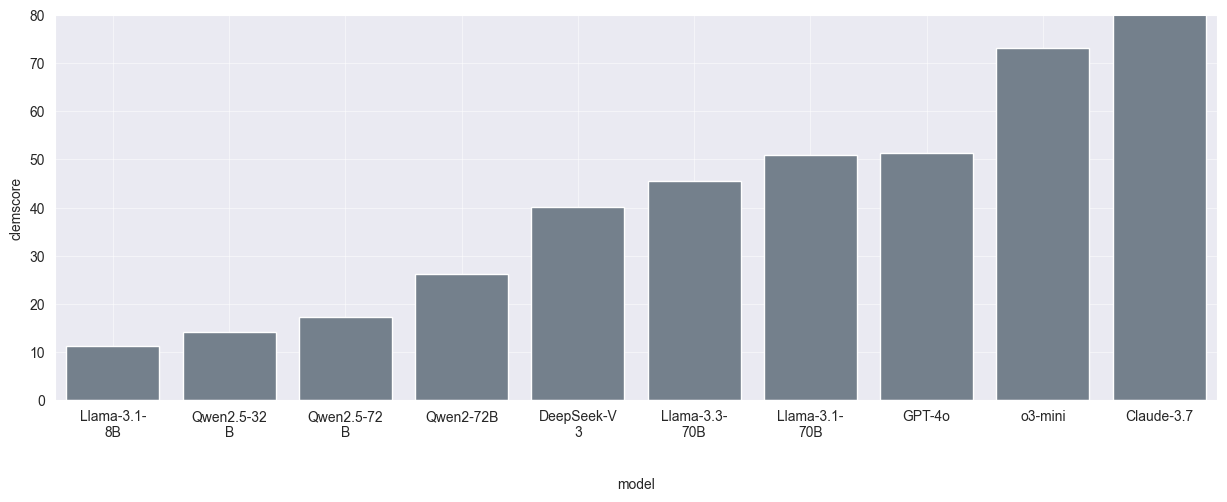

In [1140]:
clem_aux = clem_df.sort_values(by='-, clemscore').reset_index(names='model').replace(model_name_dict)
# warning, if models have matching names up the limit, results will be wrongly merged!
clem_aux['model'] = clem_aux['model'].apply(lambda x: f'{x[:10]}\n{x[10:20]}\n{x[20:30]}\n{x[30:]}')

fig = plt.figure(figsize=(15, 5))
sns.barplot(clem_aux, x='model', y='-, clemscore', color='slategray')
# plt.ylim(-5, 105)
plt.ylim(0, 80)
plt.ylabel('clemscore')
plt.grid(alpha=0.5)
plt.show()

Omit models for which all episodes were aborted due to not following prompted format for detail analysis:

In [1141]:
all_abort_models = ["LLaMA2-13B-Tiefighter"]
game_df = game_df.query('model not in ["LLaMA2-13B-Tiefighter"]')
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Claude-3.7,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Claude-3.7,basic-easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Claude-3.7,basic-easy,episode_0,Request Count,10.0
3,adventuregame,Claude-3.7,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Claude-3.7,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
69127,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_5,Played,1.0
69128,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_6,Played,0.0
69129,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_7,Played,0.0
69130,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_8,Played,0.0


## Failure metrics
### Failures by IF interpreter phase

In [1142]:
failures_by_phase_df = game_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
failures_by_phase_df

,game,model,experiment,episode,metric,value
5,adventuregame,Claude-3.7,basic-easy,episode_0,action_parsing_fail,0.0
6,adventuregame,Claude-3.7,basic-easy,episode_0,action_resolution_fail,0.0
46,adventuregame,Claude-3.7,basic-easy,episode_1,action_parsing_fail,0.0
47,adventuregame,Claude-3.7,basic-easy,episode_1,action_resolution_fail,0.0
87,adventuregame,Claude-3.7,basic-easy,episode_10,action_parsing_fail,0.0
...,...,...,...,...,...,...
67369,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_7,action_resolution_fail,14.0
67409,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_8,action_parsing_fail,0.0
67410,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_8,action_resolution_fail,15.0
67450,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_9,action_parsing_fail,0.0


Bar plot showing failures by phase for all models over all experiments:

In [1143]:
"""
fig, ax = plt.subplots(figsize=(10, 4))

g = sns.barplot(failures_by_phase_df.replace(metric_name_dict),
                x='metric',
                y='value',
                hue='model',
                ax=ax)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.ylim(0, 27)
plt.ylabel("Failures by phase")

plt.show()
"""

'\nfig, ax = plt.subplots(figsize=(10, 4))\n\ng = sns.barplot(failures_by_phase_df.replace(metric_name_dict),\n                x=\'metric\',\n                y=\'value\',\n                hue=\'model\',\n                ax=ax)\nsns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))\nplt.ylim(0, 27)\nplt.ylabel("Failures by phase")\n\nplt.show()\n'

Dataframe with parsed request counts, ie actions passed to the IF interpreter (used to calculate failure ratios):

In [1144]:
parsed_df = game_df[game_df.metric == "Parsed Request Count"].groupby(["model"]).sum()
parsed_df = parsed_df.drop(columns=["game", 'experiment', 'episode', 'metric'])
parsed_df

,value
model,
Claude-3.7,4204.0
DeepSeek-V3,4097.0
GPT-4o,4574.0
Llama-3.1-70B,4872.0
Llama-3.1-8B,6342.0
Llama-3.3-70B,3954.0
Qwen2-72B,5337.0
Qwen2.5-32B,6299.0
Qwen2.5-72B,6596.0


Counts of failures by phase for all models over all experiments:

In [1145]:
failures_by_phase_counts = failures_by_phase_df.replace(metric_name_dict).groupby(['model', 'metric']).sum()
failures_by_phase_counts = failures_by_phase_counts.drop(columns=["game", 'experiment', 'episode'])
failures_by_phase_counts

value
model         metric                    
Claude-3.7    parsing failure      134.0
              resolution failure   476.0
DeepSeek-V3   parsing failure      216.0
              resolution failure   602.0
GPT-4o        parsing failure      223.0
              resolution failure   629.0
Llama-3.1-70B parsing failure      381.0
              resolution failure   882.0
Llama-3.1-8B  parsing failure     1184.0
              resolution failure  1941.0
Llama-3.3-70B parsing failure      389.0
              resolution failure   596.0
Qwen2-72B     parsing failure     1499.0
              resolution failure   905.0
Qwen2.5-32B   parsing failure      760.0
              resolution failure  2066.0
Qwen2.5-72B   parsing failure     1453.0
              resolution failure  1481.0
human         parsing failure       17.0
              resolution failure    30.0
o3-mini       parsing failure      960.0
              resolution failure   888.0

Ratios of failures by phase for all models over all experiments (calculated by dividing failures counts by parsed request counts):

In [1146]:
failures_by_phase_ratios = failures_by_phase_counts / parsed_df
failures_by_phase_ratios

value
model         metric                      
Claude-3.7    parsing failure     0.031874
              resolution failure  0.113225
DeepSeek-V3   parsing failure     0.052722
              resolution failure  0.146937
GPT-4o        parsing failure     0.048754
              resolution failure  0.137516
Llama-3.1-70B parsing failure     0.078202
              resolution failure  0.181034
Llama-3.1-8B  parsing failure     0.186692
              resolution failure  0.306055
Llama-3.3-70B parsing failure     0.098381
              resolution failure  0.150733
Qwen2-72B     parsing failure     0.280869
              resolution failure  0.169571
Qwen2.5-32B   parsing failure     0.120654
              resolution failure  0.327989
Qwen2.5-72B   parsing failure     0.220285
              resolution failure  0.224530
human         parsing failure     0.024890
              resolution failure  0.043924
o3-mini       parsing failure     0.183066
              resolution failure  0.169336

Overview/model comparison stacked bar plot for successful actions and failures by phase:

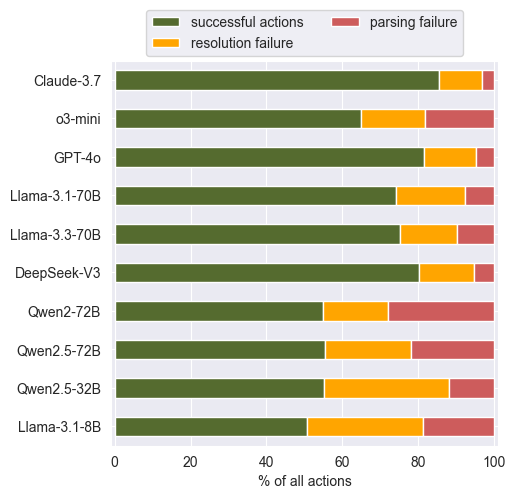

In [1147]:
STACK_COLORS = ['darkolivegreen', 'orange', 'indianred']

phase_failures = ["action_parsing_fail", "action_resolution_fail", "successful_actions"]

df_aux = game_df[game_df.metric.isin(phase_failures)]
df_aux = df_aux.replace(metric_name_dict)


df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all actions')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/action_overview_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

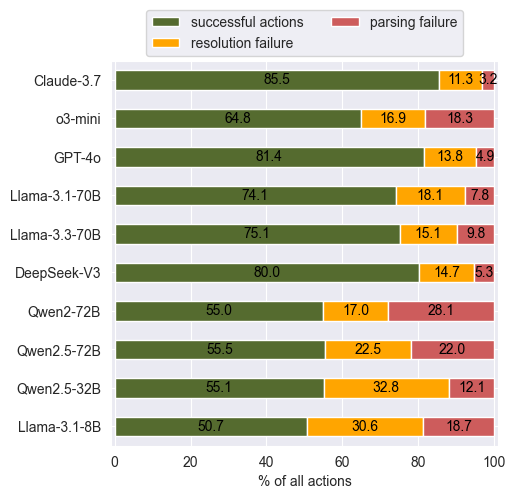

In [1148]:
STACK_COLORS = ['darkolivegreen', 'orange', 'indianred']

phase_failures = ["action_parsing_fail", "action_resolution_fail", "successful_actions"]

df_aux = game_df[game_df.metric.isin(phase_failures)]
df_aux = df_aux.replace(metric_name_dict)


df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

stacks = percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))

# print(stacks.__dict__)
# plt.bar_label(stacks, label_type='center')
# stacks.bar_label(percs)
for bar in stacks.containers:
    labels = [np.round(v.get_width(), 1) for v in bar]
    # labels = [v for v in bar]
    # for v in bar:
    #    print(v)
    #    print(v.get_width())
    #    print(type(v.get_width()))
    stacks.bar_label(bar, labels=labels, label_type='center', color='black')
    # stacks.bar_label(bar, label_type='center', color='black')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all actions')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/action_overview_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Parsing failures
Dataframe with parsing failure counts/ratios:
Note: While "undefined_action" and "undefined_argument_type" did not occur in the v1 results, they are implemented, and thus not omitted here.

In [1149]:
parsing_failures_df = game_df.query('metric in ["lark_exception", "malformed_command", "undefined_action", "undefined_action_verb", "undefined_repr_str", "undefined_argument_type"]')
parsing_failures_df = parsing_failures_df.replace(metric_name_dict)
parsing_failures_counts = parsing_failures_df.groupby(['model', 'metric']).sum()
parsing_failures_counts = parsing_failures_counts.drop(columns=["game", 'experiment', 'episode'])
parsing_failures_counts['Ratio'] = parsing_failures_counts / parsed_df
parsing_failures_counts = parsing_failures_counts.rename(columns={"value": "Count"})
parsing_failures_counts

Count     Ratio
model      metric                                
Claude-3.7 malformed command       57.0  0.013559
           out of grammar           0.0  0.000000
           undefined action type    0.0  0.000000
           undefined action verb   64.0  0.015224
           undefined antecedent     0.0  0.000000
...                                 ...       ...
o3-mini    out of grammar          34.0  0.006484
           undefined action type    0.0  0.000000
           undefined action verb  374.0  0.071320
           undefined antecedent     0.0  0.000000
           undefined noun         254.0  0.048436

[66 rows x 2 columns]

In [1150]:
parsing_failures_counts.style.format(subset="Count", precision=0).format(subset="Ratio", precision=3).to_latex('results/parsing_failures_table.tex', clines="skip-last;data")

Overview/model comparison stacked bar plot for parsing failures:
Note: Non-occurring parsing failure types are omitted here.

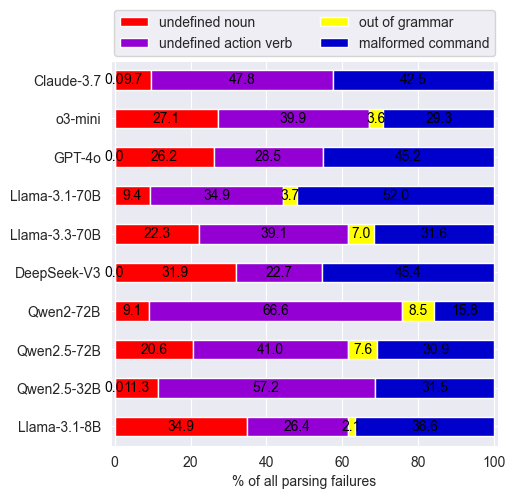

In [1151]:
STACK_COLORS = ['red', 'darkviolet', 'yellow', 'mediumblue']

parse_failures = ["lark_exception", "malformed_command", "undefined_action_verb", "undefined_repr_str"]

df_aux = game_df[game_df.metric.isin(parse_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]



df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

stacks = percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))

# print(stacks.__dict__)
# plt.bar_label(stacks, label_type='center')
# stacks.bar_label(percs)
for bar in stacks.containers:
    labels = [np.round(v.get_width(), 1) for v in bar]
    # labels = [v for v in bar]
    # for v in bar:
    #    print(v)
    #    print(v.get_width())
    #    print(type(v.get_width()))
    stacks.bar_label(bar, labels=labels, label_type='center', color='black')
    # stacks.bar_label(bar, label_type='center', color='black')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all parsing failures')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/parsing_failures_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Room/navigation failures
Dataframe with room/navigation failure counts/ratios:
Note: While "thing_arg1_room" and "thing_arg2_room" did not occur in the v1 results, they are implemented, and thus not omitted here.

In [1152]:
room_failures_df = game_df.query('metric in ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument", "thing_arg1_room", "thing_arg2_room"]')
room_failures_df = room_failures_df.replace(metric_name_dict)
room_failures_counts = room_failures_df.groupby(['model', 'metric']).sum()
room_failures_counts = room_failures_counts.drop(columns=["game", 'experiment', 'episode'])
room_failures_counts['ratio'] = room_failures_counts / parsed_df
room_failures_counts

value     ratio
model         metric                                       
Claude-3.7    going to non-adjacent room     59.0  0.014034
              interacting with other room     0.0  0.000000
              manipulating room               0.0  0.000000
DeepSeek-V3   going to non-adjacent room    142.0  0.034660
              interacting with other room     0.0  0.000000
              manipulating room               0.0  0.000000
GPT-4o        going to non-adjacent room    130.0  0.028422
              interacting with other room     0.0  0.000000
              manipulating room               0.0  0.000000
Llama-3.1-70B going to non-adjacent room    368.0  0.075534
              interacting with other room     0.0  0.000000
              manipulating room               0.0  0.000000
Llama-3.1-8B  going to non-adjacent room    507.0  0.079943
              interacting with other room    15.0  0.002365
              manipulating room               0.0  0.000000
Llama-3.3-70B going to non-adjacent room    235.0  0.059433
              interacting with other room     3.0  0.000759
              manipulating room               0.0  0.000000
Qwen2-72B     going to non-adjacent room    394.0  0.073824
              interacting with other room     8.0  0.001499
              manipulating room               0.0  0.000000
Qwen2.5-32B   going to non-adjacent room   1071.0  0.170027
              interacting with other room     0.0  0.000000
              manipulating room               1.0  0.000159
Qwen2.5-72B   going to non-adjacent room    633.0  0.095967
              interacting with other room    18.0  0.002729
              manipulating room               0.0  0.000000
human         going to non-adjacent room      1.0  0.001464
              interacting with other room     0.0  0.000000
              manipulating room               0.0  0.000000
o3-mini       going to non-adjacent room    100.0  0.019069
              interacting with other room    22.0  0.004195
              manipulating room               1.0  0.000191

Overview/model comparison stacked bar plot for room/navigation failures:
Note: Non-occurring room/navigation failure types are omitted here.

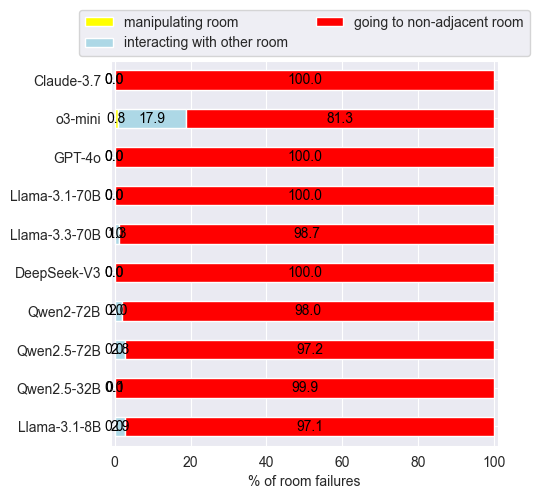

In [1153]:
STACK_COLORS = ['yellow', 'darkviolet', 'red', 'lightblue', 'yellow', 'red']

room_failures = ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument"]

df_aux = game_df[game_df.metric.isin(room_failures)]
df_aux = df_aux.replace(metric_name_dict)


df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

stacks = percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))

# print(stacks.__dict__)
# plt.bar_label(stacks, label_type='center')
# stacks.bar_label(percs)
for bar in stacks.containers:
    labels = [np.round(v.get_width(), 1) for v in bar]
    # labels = [v for v in bar]
    # for v in bar:
    #    print(v)
    #    print(v.get_width())
    #    print(type(v.get_width()))
    stacks.bar_label(bar, labels=labels, label_type='center', color='black')
    # stacks.bar_label(bar, label_type='center', color='black')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of room failures')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/nav_failures_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Entity-related failures
Dataframe with entity-related failure counts/ratios:

In [1154]:
entity_failures_df = game_df.query('metric in ["entity_not_accessible", "entity_already_inventory", "entity_state_mismatch", "entity_trait_mismatch", "inventory_limit_exceeded"]')
entity_failures_df = entity_failures_df.replace(metric_name_dict)
entity_failures_counts = entity_failures_df.groupby(['model', 'metric']).sum()
entity_failures_counts = entity_failures_counts.drop(columns=["game", 'experiment', 'episode'])
entity_failures_counts['ratio'] = entity_failures_counts / parsed_df
entity_failures_counts

value     ratio
model         metric                                      
Claude-3.7    entity already in inventory   12.0  0.002854
              entity not accessible        137.0  0.032588
              entity state mismatch        137.0  0.032588
              entity trait mismatch          1.0  0.000238
              inventory limit exceeded     122.0  0.029020
DeepSeek-V3   entity already in inventory   14.0  0.003417
              entity not accessible        182.0  0.044423
              entity state mismatch        203.0  0.049548
              entity trait mismatch          0.0  0.000000
              inventory limit exceeded      34.0  0.008299
GPT-4o        entity already in inventory   10.0  0.002186
              entity not accessible        158.0  0.034543
              entity state mismatch        192.0  0.041976
              entity trait mismatch          5.0  0.001093
              inventory limit exceeded      45.0  0.009838
Llama-3.1-70B entity already in inventory    7.0  0.001437
              entity not accessible        187.0  0.038383
              entity state mismatch        186.0  0.038177
              entity trait mismatch          3.0  0.000616
              inventory limit exceeded      89.0  0.018268
Llama-3.1-8B  entity already in inventory    2.0  0.000315
              entity not accessible        925.0  0.145853
              entity state mismatch        259.0  0.040839
              entity trait mismatch          2.0  0.000315
              inventory limit exceeded     186.0  0.029328
Llama-3.3-70B entity already in inventory    5.0  0.001265
              entity not accessible        113.0  0.028579
              entity state mismatch        181.0  0.045776
              entity trait mismatch          3.0  0.000759
              inventory limit exceeded      41.0  0.010369
Qwen2-72B     entity already in inventory   79.0  0.014802
              entity not accessible        234.0  0.043845
              entity state mismatch        115.0  0.021548
              entity trait mismatch          0.0  0.000000
              inventory limit exceeded      41.0  0.007682
Qwen2.5-32B   entity already in inventory    6.0  0.000953
              entity not accessible        515.0  0.081759
              entity state mismatch        326.0  0.051754
              entity trait mismatch          1.0  0.000159
              inventory limit exceeded      39.0  0.006191
Qwen2.5-72B   entity already in inventory  130.0  0.019709
              entity not accessible        432.0  0.065494
              entity state mismatch        202.0  0.030625
              entity trait mismatch          5.0  0.000758
              inventory limit exceeded      38.0  0.005761
human         entity already in inventory    0.0  0.000000
              entity not accessible          1.0  0.001464
              entity state mismatch         27.0  0.039531
              entity trait mismatch          0.0  0.000000
              inventory limit exceeded       1.0  0.001464
o3-mini       entity already in inventory   11.0  0.002098
              entity not accessible        489.0  0.093249
              entity state mismatch        213.0  0.040618
              entity trait mismatch          2.0  0.000381
              inventory limit exceeded       8.0  0.001526

Overview/model comparison stacked bar plot for entity-related failures:

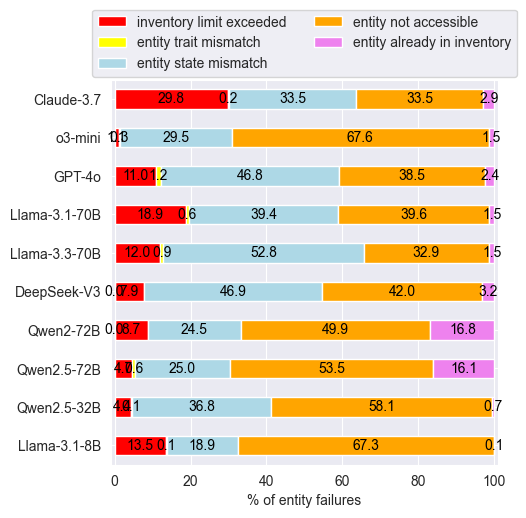

In [1155]:
STACK_COLORS = ['red', 'yellow', 'khaki', 'lightblue', 'orange', 'violet']

entity_failures = ["entity_not_accessible", "entity_already_inventory", "entity_state_mismatch", "entity_trait_mismatch", "inventory_limit_exceeded"]

df_aux = game_df[game_df.metric.isin(entity_failures)]
df_aux = df_aux.replace(metric_name_dict)


df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

stacks = percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))

# print(stacks.__dict__)
# plt.bar_label(stacks, label_type='center')
# stacks.bar_label(percs)
for bar in stacks.containers:
    labels = [np.round(v.get_width(), 1) for v in bar]
    # labels = [v for v in bar]
    # for v in bar:
    #    print(v)
    #    print(v.get_width())
    #    print(type(v.get_width()))
    stacks.bar_label(bar, labels=labels, label_type='center', color='black')
    # stacks.bar_label(bar, label_type='center', color='black')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncols=2)
plt.xlabel('% of entity failures')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/entity_failures_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

## Overview tables
Dispersion metrics over all episodes. Note that this uses groupby, which will ignore NaN values, according to the clembench documentation!

In [1156]:
stats_df = build_dispersion_table(['game', 'model', 'metric'], game_df) # could also use raw_df for results for all games
stats_df

mean        std   
game          model      metric                                         
adventuregame Claude-3.7 Aborted                   0.08750   0.283454  \
                         Lose                      0.10625   0.309125   
                         Main Score               80.62500  39.647622   
                         Parsed Request Count     26.27500  18.858276   
                         Played                    0.91250   0.283454   
...                                                    ...        ...   
              o3-mini    undefined_action          0.00000   0.000000   
                         undefined_action_verb     2.33750   4.906532   
                         undefined_argument_type   0.00000   0.000000   
                         undefined_repr_str        1.58750   4.033488   
                         world_state_discrepancy   0.00000   0.000000   

                                                          var  median    max   
game          model      metric                                                
adventuregame Claude-3.7 Aborted                     0.080346     0.0    1.0  \
                         Lose                        0.095558     0.0    1.0   
                         Main Score               1571.933962   100.0  100.0   
                         Parsed Request Count      355.634591    21.0  100.0   
                         Played                      0.080346     1.0    1.0   
...                                                       ...     ...    ...   
              o3-mini    undefined_action            0.000000     0.0    0.0   
                         undefined_action_verb      24.074057     0.0   29.0   
                         undefined_argument_type     0.000000     0.0    0.0   
                         undefined_repr_str         16.269025     0.0   21.0   
                         world_state_discrepancy     0.000000     0.0    0.0   

                                                  min      skew  
game          model      metric                                  
adventuregame Claude-3.7 Aborted                  0.0  2.947372  
                         Lose                     0.0  2.579761  
                         Main Score               0.0 -1.564415  
                         Parsed Request Count     9.0  2.313650  
                         Played                   0.0 -2.947372  
...                                               ...       ...  
              o3-mini    undefined_action         0.0  0.000000  
                         undefined_action_verb    0.0  2.597506  
                         undefined_argument_type  0.0  0.000000  
                         undefined_repr_str       0.0  3.394092  
                         world_state_discrepancy  0.0  0.000000  

[462 rows x 7 columns]

In [1157]:
failure_stats_by_phase_df = stats_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
failure_stats_by_phase_df

mean        std   
game          model         metric                                         
adventuregame Claude-3.7    action_parsing_fail      0.837500   1.700490  \
                            action_resolution_fail   2.975000   5.336418   
              DeepSeek-V3   action_parsing_fail      1.350000   3.509556   
                            action_resolution_fail   3.762500   7.137013   
              GPT-4o        action_parsing_fail      1.393750   3.377873   
                            action_resolution_fail   3.931250   6.370255   
              Llama-3.1-70B action_parsing_fail      2.381250   6.323433   
                            action_resolution_fail   5.512500   9.289872   
              Llama-3.1-8B  action_parsing_fail      7.400000  14.411386   
                            action_resolution_fail  12.131250  11.476047   
              Llama-3.3-70B action_parsing_fail      2.431250   3.848747   
                            action_resolution_fail   3.725000   4.080865   
              Qwen2-72B     action_parsing_fail      9.368750  14.736948   
                            action_resolution_fail   5.656250   5.764833   
              Qwen2.5-32B   action_parsing_fail      4.750000  12.718036   
                            action_resolution_fail  12.912500  18.091447   
              Qwen2.5-72B   action_parsing_fail      9.081250  14.697354   
                            action_resolution_fail   9.256250   9.505541   
              human         action_parsing_fail      0.369565   0.741131   
                            action_resolution_fail   0.652174   1.594677   
              o3-mini       action_parsing_fail      6.000000  10.946985   
                            action_resolution_fail   5.550000   8.637930   

                                                           var  median   max   
game          model         metric                                             
adventuregame Claude-3.7    action_parsing_fail       2.891667     0.0  10.0  \
                            action_resolution_fail   28.477358     0.5  25.0   
              DeepSeek-V3   action_parsing_fail      12.316981     0.0  22.0   
                            action_resolution_fail   50.936950     1.5  50.0   
              GPT-4o        action_parsing_fail      11.410024     0.0  19.0   
                            action_resolution_fail   40.580149     2.0  50.0   
              Llama-3.1-70B action_parsing_fail      39.985810     0.0  44.0   
                            action_resolution_fail   86.301730     2.0  56.0   
              Llama-3.1-8B  action_parsing_fail     207.688050     0.0  77.0   
                            action_resolution_fail  131.699646     8.0  64.0   
              Llama-3.3-70B action_parsing_fail      14.812854     1.0  21.0   
                            action_resolution_fail   16.653459     2.0  28.0   
              Qwen2-72B     action_parsing_fail     217.177634     3.0  50.0   
                            action_resolution_fail   33.233294     3.5  33.0   
              Qwen2.5-32B   action_parsing_fail     161.748428     0.0  50.0   
                            action_resolution_fail  327.300472     6.0  82.0   
              Qwen2.5-72B   action_parsing_fail     216.012225     2.0  50.0   
                            action_resolution_fail   90.355307     6.5  54.0   
              human         action_parsing_fail       0.549275     0.0   3.0   
                            action_resolution_fail    2.542995     0.0   8.0   
              o3-mini       action_parsing_fail     119.836478     0.0  48.0   
                            action_resolution_fail   74.613836     1.0  33.0   

                                                    min      skew  
game          model         metric                                 
adventuregame Claude-3.7    action_parsing_fail     0.0  2.565606  
                            action_resolution_fail  0.0  2.145684  
              DeepSeek-V3   action_pars

Break results down by experiment:

In [1158]:
detailed_stats_df = build_dispersion_table(['game', 'model', 'experiment', 'metric'], game_df) # could also use raw_df for results for all games
detailed_stats_df

mean   
game          model      experiment     metric                             
adventuregame Claude-3.7 basic-easy     Aborted                   0.0000  \
                                        Lose                      0.2500   
                                        Main Score               75.0000   
                                        Parsed Request Count     14.6250   
                                        Played                    1.0000   
...                                                                  ...   
              o3-mini    potion-brewing undefined_action          0.0000   
                                        undefined_action_verb     9.9375   
                                        undefined_argument_type   0.0000   
                                        undefined_repr_str        9.9375   
                                        world_state_discrepancy   0.0000   

                                                                       std   
game          model      experiment     metric                               
adventuregame Claude-3.7 basic-easy     Aborted                   0.000000  \
                                        Lose                      0.447214   
                                        Main Score               44.721360   
                                        Parsed Request Count      2.825479   
                                        Played                    0.000000   
...                                                                    ...   
              o3-mini    potion-brewing undefined_action          0.000000   
                                        undefined_action_verb     7.433875   
                                        undefined_argument_type   0.000000   
                                        undefined_repr_str        7.325469   
                                        world_state_discrepancy   0.000000   

                                                                         var   
game          model      experiment     metric                                 
adventuregame Claude-3.7 basic-easy     Aborted                     0.000000  \
                                        Lose                        0.200000   
                                        Main Score               2000.000000   
                                        Parsed Request Count        7.983333   
                                        Played                      0.000000   
...                                                                      ...   
              o3-mini    potion-brewing undefined_action            0.000000   
                                        undefined_action_verb      55.262500   
                                        undefined_argument_type     0.000000   
                                        undefined_repr_str         53.662500   
                                        world_state_discrepancy     0.000000   

                                                                 median   
game          model      experiment     metric                            
adventuregame Claude-3.7 basic-easy     Aborted                     0.0  \
                                        Lose                        0.0   
                                        Main Score                100.0   
                                        Parsed Request Count       15.0   
                                        Played                      1.0   
...                                                                 ...   
              o3-mini    potion-brewing undefined_action            0.0   
                                        undefined_action_verb       8.0   
                                        undefined_argument_type     0.0   
                                        undefined_repr_str          8.0   
                                        world_state_discrepancy     0.0   

                                               

In [1159]:
stats_df.to_csv('results/adventuregame_stats.csv')
detailed_stats_df.to_csv('results/adventuregame_stats_detailed.csv')

In [1160]:
stats_df.to_html('results/adventuregame_stats.html')
detailed_stats_df.to_html('results/adventuregame_stats_detailed.html')

Condensed tables:

In [1161]:
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Claude-3.7,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Claude-3.7,basic-easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Claude-3.7,basic-easy,episode_0,Request Count,10.0
3,adventuregame,Claude-3.7,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Claude-3.7,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
69127,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_5,Played,1.0
69128,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_6,Played,0.0
69129,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_7,Played,0.0
69130,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_8,Played,0.0


In [1162]:
selected_stats_df = game_df.drop(columns=["game"])
selected_metrics_list = ["Main Score", "Played", "Success", "action_parsing_fail", "action_resolution_fail", "successful_actions"]
selected_stats_df = selected_stats_df.query('metric in ["Main Score", "Played"]')
selected_stats_df = build_dispersion_table(['model', 'experiment', 'metric'], selected_stats_df)
selected_stats_df = selected_stats_df.drop(columns=["var", "median", "max", "min", "skew"])
selected_stats_df = selected_stats_df.rename(metric_name_dict)
selected_stats_df = selected_stats_df.rename({"Main Score": "Score"})
selected_stats_df = selected_stats_df.reset_index()
selected_stats_df = pd.pivot_table(selected_stats_df, index=['model', 'experiment'], columns='metric')
selected_stats_df

mean              std           
metric                          Played  Score    Played      Score
model      experiment                                             
Claude-3.7 basic-easy           1.0000  75.00  0.000000  44.721360
           basic-easy-invlimit  1.0000  81.25  0.000000  40.311289
           basic-easy-preexp    1.0000  75.00  0.000000  44.721360
           basic-hard           0.9375  81.25  0.250000  40.311289
           basic-hard-invlimit  0.9375  93.75  0.250000  25.000000
...                                ...    ...       ...        ...
o3-mini    basic-hard-preexp    0.7500  75.00  0.447214  44.721360
           new-words-easy       1.0000  87.50  0.000000  34.156503
           new-words-hard       0.9375  87.50  0.250000  34.156503
           new-words-medium     0.4375  43.75  0.512348  51.234754
           potion-brewing       0.1250  12.50  0.341565  34.156503

[110 rows x 4 columns]

In [1163]:
selected_stats_df.to_html("results/selected_stats.html")

In [1164]:
selected_stats_styled = selected_stats_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=2)
selected_stats_styled.to_latex("results/selected_stats.tex", clines="skip-last;data")

Limit to selected top models:

In [1165]:
top_stats_df = game_df.drop(columns=["game"])
# top_stats_df = top_stats_df.query('metric in ["Main Score", "Played", "Success", "hallucination_count"]')
# top_stats_df = top_stats_df.query('metric in ["Main Score", "Played", "achieved_goal_rating"]')
# top_stats_df = top_stats_df.query('metric in ["Main Score", "Played", "achieved_goal_rating", "plan_average_viability_ratio", "hallucination_count"]')
top_stats_df = top_stats_df.query('metric in ["Main Score", "Played", "achieved_goal_rating", "hallucination_count"]')
top_stats_df = top_stats_df.query("model in ['human', 'o3-mini', 'Claude-3.7', 'Llama-3.1-70B', 'Qwen2.5-32B', 'GPT-4o', 'Llama-3.1-8B', 'Qwen2.5-72B', 'Qwen2-72B', 'Llama-3.3-70B', 'DeepSeek-V3']")

# top_stats_df = top_stats_df.query("experiment in ['basic-easy', 'basic-easy-invlimit', 'basic-easy-preexplore', 'basic-hard', 'basic-hard-invlimit', 'basic-hard-preexplore', 'new-words-easy', 'new-words-medium', 'new-words-hard']")
top_stats_df = top_stats_df.query("experiment in ['basic-easy', 'basic-hard', 'basic-easy-preexp', 'basic-hard-preexp', 'basic-easy-invlimit', 'basic-hard-invlimit', 'new-words-easy', 'new-words-medium', 'new-words-hard', 'potion-brewing']")

top_stats_df = build_dispersion_table(['model', 'experiment', 'metric'], top_stats_df)
top_stats_df = top_stats_df.drop(columns=["var", "median", "max", "min", "skew", "std"])
top_stats_df = top_stats_df.rename(metric_name_dict)
top_stats_df = top_stats_df.rename({"Main Score": "Quality"})
top_stats_df = top_stats_df.rename({"Played": "% Played"})
# top_stats_df = top_stats_df.rename({"Success": "% Success"})
top_stats_df = top_stats_df.rename({"hallucination_count": "% Hal."})
top_stats_df = top_stats_df.rename({"achieved_goal_rating": "% Goals"})
# top_stats_df = top_stats_df.rename({"plan_average_viability_ratio": "Plan Viability"})
top_stats_df = top_stats_df.reset_index()
top_stats_df = pd.pivot_table(top_stats_df, index=['model', 'experiment'], columns='metric')
top_stats_df[('metric', 'clemscore')] = top_stats_df[('mean', '% Played')] * top_stats_df[('mean', 'Quality')]
top_stats_df[('metric', 'Quality')] = top_stats_df[('mean', 'Quality')]
top_stats_df[('metric', '% Played')] = top_stats_df[('mean', '% Played')] * 100
top_stats_df[('metric', "% Lose")] = top_stats_df[('mean', "% Hal.")] * 100
top_stats_df[('metric', 'Goal Rate')] = top_stats_df[('mean', '% Goals')]
# top_stats_df[('metric', 'Plan Viability')] = top_stats_df[('mean', 'Plan Viability')] * 100
# top_stats_df[('metric', '% Success')] = top_stats_df[('mean', '% Success')] * 100
# top_stats_df = top_stats_df.drop(columns=[("mean", '% Played'), ("mean", '% Success'), ("mean", 'Quality'), ('mean', "% Hal.")])
# top_stats_df = top_stats_df.drop(columns=[("mean", '% Played'), ("mean", 'Quality'), ('mean', '% Goals'), ('mean', 'Plan Viability'), ('mean', "% Hal.")])
top_stats_df = top_stats_df.drop(columns=[("mean", '% Played'), ("mean", 'Quality'), ('mean', '% Goals'), ('mean', "% Hal.")])
top_stats_df

metric                                   
metric                          clemscore Quality % Played % Lose  Goal Rate
model      experiment                                                       
Claude-3.7 basic-easy           75.000000   75.00   100.00  25.00  75.000000
           basic-easy-invlimit  81.250000   81.25   100.00  18.75  81.250000
           basic-easy-preexp    75.000000   75.00   100.00  25.00  75.000000
           basic-hard           76.171875   81.25    93.75  12.50  91.666667
           basic-hard-invlimit  87.890625   93.75    93.75   0.00  95.833333
...                                   ...     ...      ...    ...        ...
o3-mini    basic-hard-preexp    56.250000   75.00    75.00   0.00  83.333333
           new-words-easy       87.500000   87.50   100.00  12.50  95.833333
           new-words-hard       82.031250   87.50    93.75   6.25  91.666667
           new-words-medium     19.140625   43.75    43.75   0.00  66.666667
           potion-brewing        1.562500   12.50    12.50  12.50  12.500000

[110 rows x 5 columns]

In [1166]:
top_stats_df.to_html("results/top_model_experiment_stats.html")

In [1167]:
top_stats_df.to_csv("results/top_model_experiment_stats.csv")

In [1168]:
top_stats_styled = top_stats_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=1)
top_stats_styled.to_latex("results/top_model_experiment_stats.tex", clines="skip-last;data")

Hallucinations:

In [1169]:
hallucination_df = game_df[game_df.metric == 'hallucination_count']
hallucination_df

,game,model,experiment,episode,metric,value
4,adventuregame,Claude-3.7,basic-easy,episode_0,hallucination_count,0.0
45,adventuregame,Claude-3.7,basic-easy,episode_1,hallucination_count,0.0
86,adventuregame,Claude-3.7,basic-easy,episode_10,hallucination_count,0.0
127,adventuregame,Claude-3.7,basic-easy,episode_11,hallucination_count,0.0
168,adventuregame,Claude-3.7,basic-easy,episode_12,hallucination_count,1.0
...,...,...,...,...,...,...
67285,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_5,hallucination_count,1.0
67326,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_6,hallucination_count,0.0
67367,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_7,hallucination_count,0.0
67408,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_8,hallucination_count,0.0


In [1170]:
llama3_1_70b_hallu = hallucination_df.query('model == "Llama-3.1-70b-Instruct" and value == 1')
llama3_1_70b_hallu

,game,model,experiment,episode,metric,value


In [1171]:
openchat_hallu = hallucination_df.query('model == "openchat3.5" and value == 1')
openchat_hallu

,game,model,experiment,episode,metric,value


In [1172]:
hallucination_counts = hallucination_df.groupby(['model']).sum()
hallucination_sums = hallucination_counts.iloc[0:19, [4]]
# hallucination_sums['Ratio'] = hallucination_sums.value / 64
hallucination_sums['Percentage'] = (hallucination_sums.value / 128) * 100
hallucination_sums = hallucination_sums.rename(columns = {"value": "Total"})
hallucination_sums

,Total,Percentage
model,,
Claude-3.7,19.0,14.84375
DeepSeek-V3,71.0,55.46875
GPT-4o,62.0,48.43750
Llama-3.1-70B,67.0,52.34375
Llama-3.1-8B,36.0,28.12500
Llama-3.3-70B,90.0,70.31250
Qwen2-72B,64.0,50.00000
Qwen2.5-32B,50.0,39.06250
Qwen2.5-72B,55.0,42.96875


In [1173]:
hallucination_sums.to_html('results/hallucination_sums.html')

In [1174]:
h_styled = hallucination_sums.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="Percentage", precision=3).format(subset="Total", precision=0)
h_styled.to_latex('results/hallucination_sums.tex')

In [1175]:
h_styled = hallucination_sums.style.format(subset="Percentage", precision=1).format(subset="Total", precision=0).to_latex('results/hallucination_sums.tex', clines="skip-last;data")

In [1176]:
detailed_hallucination_df = build_dispersion_table(['model'], hallucination_df)
detailed_hallucination_df

,mean,std,var,median,max,min,skew
model,,,,,,,
Claude-3.7,0.11875,0.324510,0.105307,0.0,1.0,0.0,2.379441
DeepSeek-V3,0.44375,0.498386,0.248388,0.0,1.0,0.0,0.228586
GPT-4o,0.38750,0.488709,0.238836,0.0,1.0,0.0,0.466224
Llama-3.1-70B,0.41875,0.494903,0.244929,0.0,1.0,0.0,0.332503
Llama-3.1-8B,0.22500,0.418893,0.175472,0.0,1.0,0.0,1.329603
Llama-3.3-70B,0.56250,0.497636,0.247642,1.0,1.0,0.0,-0.254367
Qwen2-72B,0.40000,0.491436,0.241509,0.0,1.0,0.0,0.412122
Qwen2.5-32B,0.31250,0.464968,0.216195,0.0,1.0,0.0,0.816717
Qwen2.5-72B,0.34375,0.476450,0.227005,0.0,1.0,0.0,0.664195


## Specific metrics plots
Bar plot overview by model and experiment:

In [1177]:
def metric_bar_plot(source_df, metric, max_value=1):
    metric_df = source_df[game_df.metric == metric].sort_values('experiment')
    fig, ax = plt.subplots(figsize=(14, 4))

    g = sns.barplot(metric_df,
                x='experiment',
                y='value',
                hue='model', 
                ax=ax)

    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.ylim(0, max_value)
    plt.ylabel(metric)

    plt.show()

In [1178]:
# metric_bar_plot(game_df, "Main Score", max_value=100)

# Aborted episodes stacked bars

In [1179]:
abort_metrics_turn = ["command_tag_missing", "next_actions_missing", "hallucination"]
abort_metrics_ep = ["turn_limit_loss"]

In [1180]:
def get_episode_abort_metrics(model_id: str, variant: str, episode: str):
    abort_dict = {"turn_limit": 0, "command_tag_missing": 0, "next_actions_missing": 0, "hallucination": 0}
    # load episode scores from JSON:
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    # check episode scores:
    ep_scores = scores['episode scores']
    if ep_scores["Aborted"] == 1:
        abort_dict["turn_limit"] = ep_scores["turn_limit_loss"]
    # check turn scores:
    if 'round scores' in scores:
        turns_scores = scores['round scores']
    elif 'turn scores' in scores:
        turns_scores = scores['turn scores']
    else:
        print(f"Neither turn nor round scores for {model_id} {variant} {episode}")
    for turn_scores in turns_scores.values():
        if turn_scores["command_tag_missing"] == 1:
            abort_dict["command_tag_missing"] = turn_scores["command_tag_missing"]
            if turn_scores["hallucination"] == 1:
                abort_dict["hallucination"] = turn_scores["hallucination"]
            break
        if turn_scores["next_actions_missing"] == 1:
            abort_dict["next_actions_missing"] = turn_scores["next_actions_missing"]
            break

    return abort_dict

In [1181]:
# model_id = "o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0"
# variant = "1_home_deliver_three_planning_easy"
# episode = "episode_3"
# episode = "episode_9"
# get_episode_abort_metrics(model_id, variant, episode)

In [1182]:
def get_abort_metrics(model_id: str, variants: list):
    episodes = [f"episode_{number}" for number in range(0,16)]
    overall_abort_dict = {"turn_limit": 0, "command_tag_missing": 0, "next_actions_missing": 0, "hallucination": 0}
    for variant in variants:
        for episode in episodes:
            cur_abort_dict = get_episode_abort_metrics(model_id, variant, episode)
            for key, val in cur_abort_dict.items():
                # print(key, val)
                overall_abort_dict[key] += val

    return overall_abort_dict

In [1183]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

# get_abort_metrics("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants)

In [1184]:
def get_model_set_abort_metrics(model_ids: list, variants: list):
    abort_totals = dict()
    for model_id in model_ids:
        overall_abort_dict = get_abort_metrics(model_id, variants)
        abort_totals[model_name_dict[model_id]] = overall_abort_dict

    return abort_totals

In [1185]:
all_models_all_abort = get_model_set_abort_metrics(final_models, variants)
all_models_all_abort

{'Claude-3.7': {'turn_limit': 3,
  'command_tag_missing': 0,
  'next_actions_missing': 0,
  'hallucination': 0},
 'o3-mini': {'turn_limit': 18,
  'command_tag_missing': 0,
  'next_actions_missing': 0,
  'hallucination': 0},
 'GPT-4o': {'turn_limit': 8,
  'command_tag_missing': 0,
  'next_actions_missing': 0,
  'hallucination': 0},
 'Llama-3.1-70B': {'turn_limit': 16,
  'command_tag_missing': 0,
  'next_actions_missing': 0,
  'hallucination': 0},
 'Llama-3.3-70B': {'turn_limit': 11,
  'command_tag_missing': 1,
  'next_actions_missing': 0,
  'hallucination': 0},
 'DeepSeek-V3': {'turn_limit': 20,
  'command_tag_missing': 1,
  'next_actions_missing': 0,
  'hallucination': 0},
 'Qwen2.5-32B': {'turn_limit': 71,
  'command_tag_missing': 0,
  'next_actions_missing': 0,
  'hallucination': 0},
 'Qwen2-72B': {'turn_limit': 53,
  'command_tag_missing': 2,
  'next_actions_missing': 0,
  'hallucination': 0},
 'Qwen2.5-72B': {'turn_limit': 69,
  'command_tag_missing': 0,
  'next_actions_missing': 0

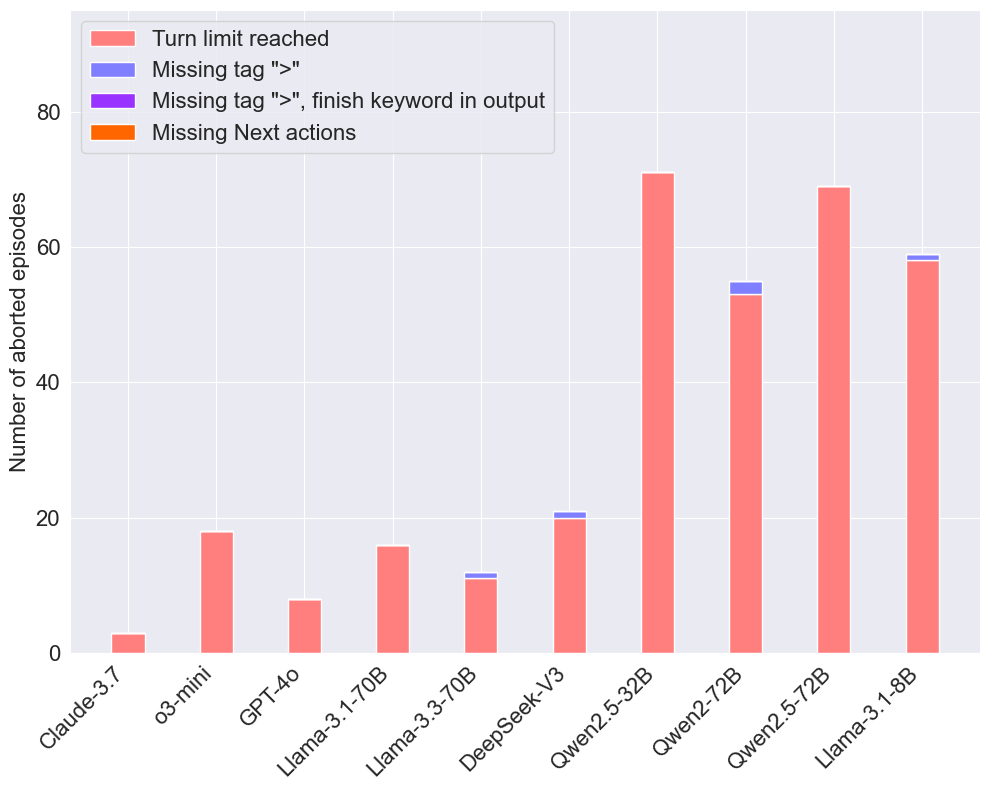

In [1186]:
abort_metrics_turn = ["command_tag_missing", "next_actions_missing", "hallucination"]
abort_metrics_ep = ["turn_limit_loss"]

# Prepare data for plotting
models = list()

turn_limit_losses = list()
command_tag_missings = list()
next_actions_missings = list()
hallucinations = list()

# opponent_faster_losses = []

for model_name, abort_data in all_models_all_abort.items():
    # Create shorter model name for display
    # short_name = model_name.split('-t0.0--')[0].split('-2024')[0].split('-2025')[0].replace('-Instruct', '').replace('-flash-exp', '').replace('-sonnet', '')
    models.append(model_name)

    # Get abort counts, default to 0 if not present
    turn_limit_losses.append(abort_data.get('turn_limit', 0))
    command_tag_missings.append(abort_data.get('command_tag_missing', 0))
    next_actions_missings.append(abort_data.get('next_actions_missing', 0))
    hallucinations.append(abort_data.get('hallucination', 0))

# print(models)

turn_limit_losses = np.array(turn_limit_losses)
command_tag_missings = np.array(command_tag_missings)
next_actions_missings = np.array(next_actions_missings)
hallucinations = np.array(hallucinations)

hallu_sub_tag_missings = command_tag_missings - hallucinations

# Set up the plot
plt.figure(figsize=(10, 8))

# Set the width of each bar and positions of the bars
width = 0.3
x = np.arange(len(models)) * 0.8  # Reduce spacing between bars

plt.ylim([0,95])

# Create the stacked bars
plt.bar(x, turn_limit_losses, width, label='Turn limit reached', color='#ff7f7f')
plt.bar(x, hallu_sub_tag_missings, width, bottom=turn_limit_losses, label='Missing tag ">"', color='#7f7fff')
plt.bar(x, hallucinations, width, bottom=hallu_sub_tag_missings + turn_limit_losses, label='Missing tag ">", finish keyword in output', color='#9933FF')
plt.bar(x, next_actions_missings, width, bottom=hallu_sub_tag_missings + turn_limit_losses + hallucinations, label='Missing Next actions', color='#FF6600')

# Customize the plot
plt.ylabel('Number of aborted episodes', fontsize=16)
# plt.title('Abort Distribution by Model', fontsize=16)
plt.xticks(x, models, rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc='upper left')
# plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig('results/aborts_distribution.pdf', dpi=300, bbox_inches='tight')

# plt.close()
plt.show()

## Exploration

In [1187]:
# get single episode for exploration line plot
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "0_home_deliver_three_basic_easy"
episode = "episode_0"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
if 'round scores' in scores:
    turn_scores = scores['round scores']
elif 'turn scores' in scores:
    turn_scores = scores['turn scores']
else:
    print(f"Neither turn nor round scores for {model_id} {variant} {episode}")
# turn_scores = scores['turn scores']
turns_known_entities_ratio = [score_values['known_entities_ratio'] for score_values in turn_scores.values()]
turns_known_entities_ratio

[0.13793103448275862,
 0.13793103448275862,
 0.13793103448275862,
 0.1724137931034483,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552]

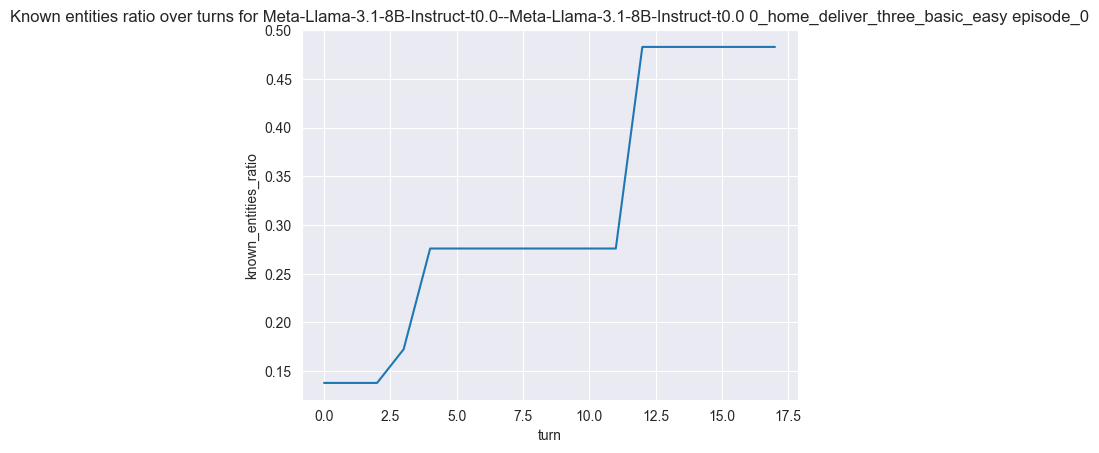

In [1188]:
fig, ax = plt.subplots()
ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'Known entities ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [1189]:
# get single episode for exploration line plot
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
# variant = "1_home_deliver_three_planning_easy"
variant = "0_home_deliver_three_basic_easy"
episode = "episode_0"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
if 'round scores' in scores:
    turn_scores = scores['round scores']
elif 'turn scores' in scores:
    turn_scores = scores['turn scores']
else:
    print(f"Neither turn nor round scores for {model_id} {variant} {episode}")
# turn_scores = scores['turn scores']
# turns_plan_command_success_ratio = [score_values['plan_command_success_ratio'] for score_values in turn_scores.values()]
turns_known_entities_ratio = [score_values['known_entities_ratio'] for score_values in turn_scores.values()]
turns_known_goal_entities_ratio = [score_values['known_goal_entities_ratio'] for score_values in turn_scores.values()]
# turns_plan_command_success_ratio

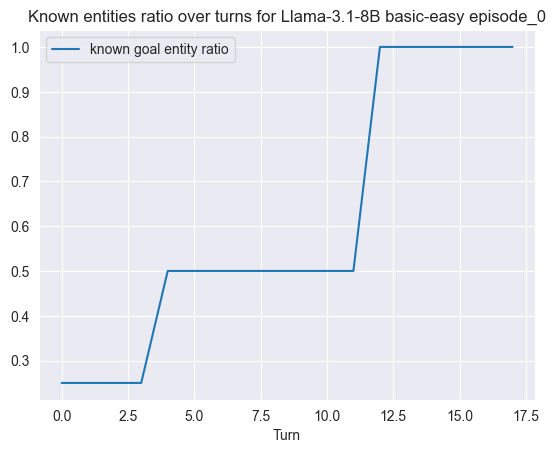

In [1190]:
fig, ax = plt.subplots()

# ax.plot(turns_known_entities_ratio)
ax.plot(turns_known_goal_entities_ratio)
 #ax.plot(turns_plan_command_success_ratio)

ax.set(xlabel='Turn',
       title=f'Known entities ratio over turns for {model_name_dict[model_id]} {experiment_short_name_dict[variant]} {episode}')
# ax.grid()
ax.legend(['known goal entity ratio', 'plan viability'], loc='upper left')

# fig.savefig("test.png")
plt.show()

In [1191]:
def get_score_progress_list(model_id: str, variant: str, episode: str, score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    if 'round scores' in scores:
        turn_scores = scores['round scores']
    elif 'turn scores' in scores:
        turn_scores = scores['turn scores']
    turns_score = [score_values[score] for score_values in turn_scores.values()]
    return turns_score

In [1192]:
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "0_home_deliver_three_basic_easy"
episodes = [f"episode_{number}" for number in range(0,16)]

def get_exploration_progress_list(model_id: str, variant: str, episode: str, exploration_score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    if 'round scores' in scores:
        turn_scores = scores['round scores']
    elif 'turn scores' in scores:
        turn_scores = scores['turn scores']
    turns_exploration_score = [score_values[exploration_score] for score_values in turn_scores.values()]
    return turns_exploration_score

get_exploration_progress_list(model_id, variant, episodes[0], "known_entities_ratio")

[0.13793103448275862,
 0.13793103448275862,
 0.13793103448275862,
 0.1724137931034483,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552]

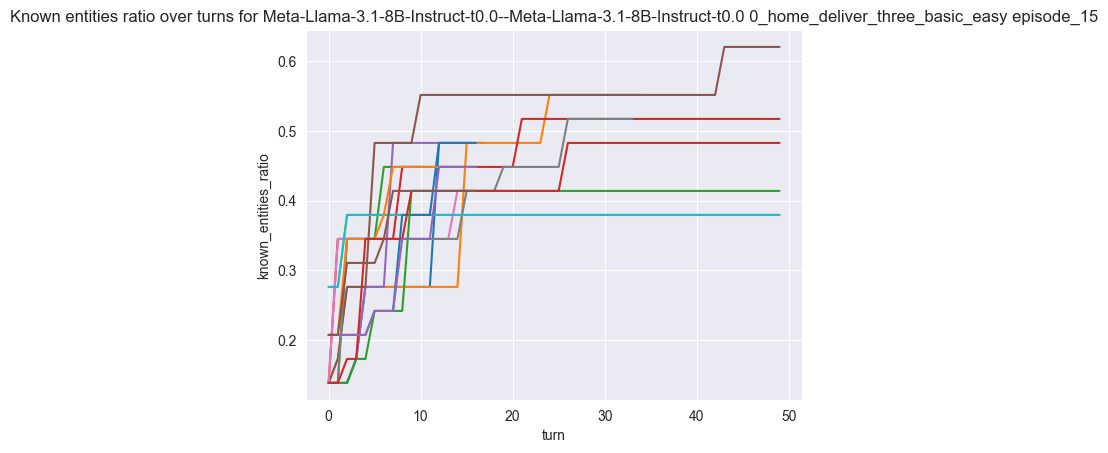

In [1193]:
fig, ax = plt.subplots()

for episode in episodes:
    turns_known_entities_ratio = get_exploration_progress_list(model_id, variant, episode, "known_entities_ratio")
    ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'Known entities ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

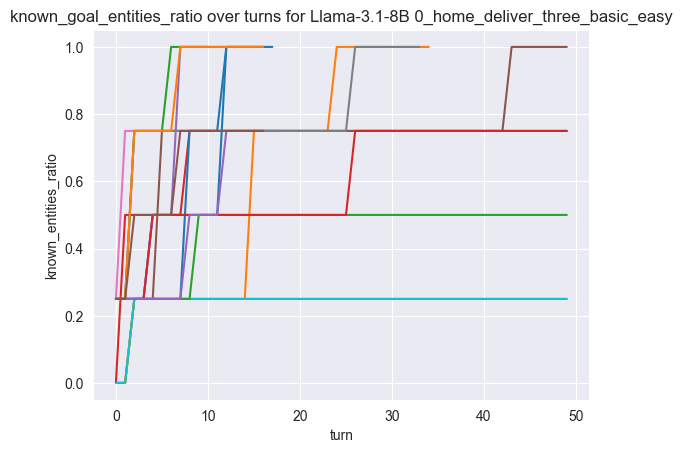

In [1194]:
exploration_score = "known_goal_entities_ratio"

fig, ax = plt.subplots()

for episode in episodes:
    turns_known_entities_ratio = get_exploration_progress_list(model_id, variant, episode, exploration_score)
    ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'{exploration_score} over turns for {model_name_dict[model_id]} {variant}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [1195]:
def get_exploration_progress_list(model_id: str, variant: str, episode: str, exploration_score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    if 'round scores' in scores:
        turn_scores = scores['round scores']
    elif 'turn scores' in scores:
        turn_scores = scores['turn scores']
    turns_exploration_score = [score_values[exploration_score] for score_values in turn_scores.values()]
    return turns_exploration_score

## Over all turns

In [1196]:
def get_score_progress_list(model_id: str, variant: str, episode: str, score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    if 'round scores' in scores:
        turn_scores = scores['round scores']
    elif 'turn scores' in scores:
        turn_scores = scores['turn scores']
    turns_score = list()
    for turn_idx, turn_scores_value in enumerate(turn_scores.values()):
        if score in turn_scores_value:
            turns_score.append(turn_scores_value[score])
        else:
            print(f"{score} not in turn {turn_idx} of {model_id} {variant} {episode}")
            turns_score.append(np.nan)

    return turns_score

In [1197]:
# get_score_progress_list("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", "1_home_deliver_three_planning_easy", "episode_3", "known_entities_ratio")

In [1198]:
def get_avg_turns_score(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    averages_array = np.nanmean(progress_array, axis=0)

    return averages_array

In [1199]:
def get_avg_last_turns_score(model_id: str, variants: list, score: str, n_turns: int):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_progress_lists = list()
    ep_count = 0
    for variant in variants:
        for episode in episodes:
            plan_viability_progress_list = get_score_progress_list(model_id, variant, episode, score)
            if len(plan_viability_progress_list) >= n_turns:
                list_of_progress_lists.append(plan_viability_progress_list)
                ep_count += 1
    print(f"{ep_count} viable episodes for {model_id}")
    last_n = [ep_list[-n_turns:] for ep_list in list_of_progress_lists]
    avg_last_n = list()
    for turn_idx in range(n_turns):
        turn_sum = sum([turn[turn_idx] for turn in last_n])
        avg_last_n.append(turn_sum / ep_count)

    return avg_last_n

## Epistemic/Pragmatic

In [1200]:
# variants = ["1_home_deliver_three_planning_easy", "3_home_deliver_three_planning_easy_invlimittwo",
#           "5_home_deliver_three_planning_hard", "7_home_deliver_three_planning_hard_invlimittwo"]

# variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
#            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
#            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

# variants = ["1_home_deliver_three_planning_easy"]

# variants = ["0_home_deliver_three_basic_easy"]

variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]


# get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "known_entities_ratio")

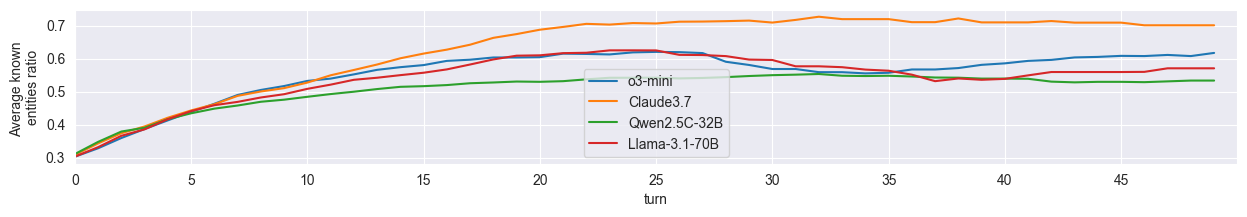

In [1201]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "known_entities_ratio"), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, "known_entities_ratio"), label="Claude3.5")
ax.plot(get_avg_turns_score("claude-3-7-sonnet-20250219-t0.0--claude-3-7-sonnet-20250219-t0.0", variants, "known_entities_ratio"), label="Claude3.7")
# ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, "known_entities_ratio"), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, "known_entities_ratio"), label="Qwen2.5C-32B")
# ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, "known_entities_ratio"), label="Llama-3.1-8B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0", variants, "known_entities_ratio"), label="Llama-3.1-70B")

metric_name = "known \nentities ratio"

ax.set(xlabel='turn', ylabel=f'Average {metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

# plt.ylim([0,0.3])
# plt.yticks(np.arange(0, 0.25, step=0.2))


# plt.legend(bbox_to_anchor=(0.83, 1.1), loc="upper right")
# plt.legend()
plt.legend(loc="lower center")

fig.savefig("results/top_models_known_entities_ratio_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_known_entities_ratio_all.png")

plt.show()

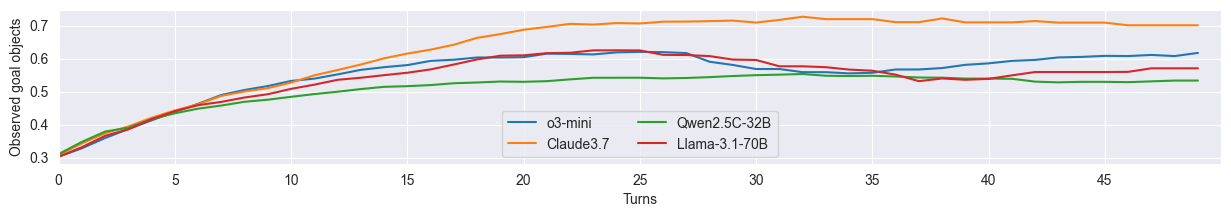

In [1202]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "known_goal_entities_ratio"

ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "known_entities_ratio"), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, "known_entities_ratio"), label="Claude3.5")
ax.plot(get_avg_turns_score("claude-3-7-sonnet-20250219-t0.0--claude-3-7-sonnet-20250219-t0.0", variants, "known_entities_ratio"), label="Claude3.7")
# ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, "known_entities_ratio"), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, "known_entities_ratio"), label="Qwen2.5C-32B")
# ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, "known_entities_ratio"), label="Llama-3.1-8B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0", variants, "known_entities_ratio"), label="Llama-3.1-70B")

metric_name = "Observed goal objects"

ax.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend(ncols=2, loc='lower center')

fig.savefig("results/known_goal_entities_ratio.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/known_goal_entities_ratio.png")

plt.show()

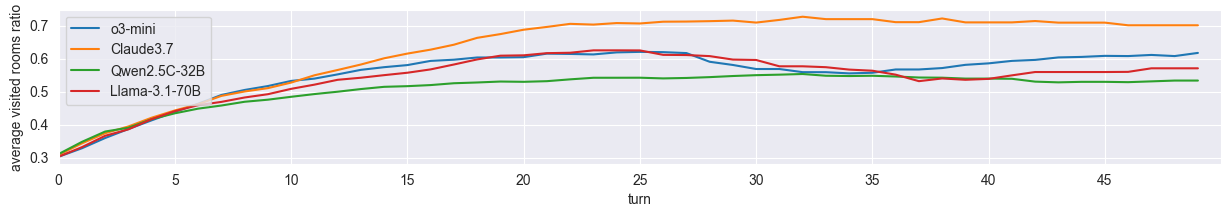

In [1203]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "visited_rooms_ratio"

ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "known_entities_ratio"), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, "known_entities_ratio"), label="Claude3.5")
ax.plot(get_avg_turns_score("claude-3-7-sonnet-20250219-t0.0--claude-3-7-sonnet-20250219-t0.0", variants, "known_entities_ratio"), label="Claude3.7")
# ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, "known_entities_ratio"), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, "known_entities_ratio"), label="Qwen2.5C-32B")
# ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, "known_entities_ratio"), label="Llama-3.1-8B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0", variants, "known_entities_ratio"), label="Llama-3.1-70B")

metric_name = "visited rooms ratio"

ax.set(xlabel='turn', ylabel=f'average {metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

fig.savefig("results/top_models_visited_rooms_ratio_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_visited_rooms_ratio_all.png")

plt.show()

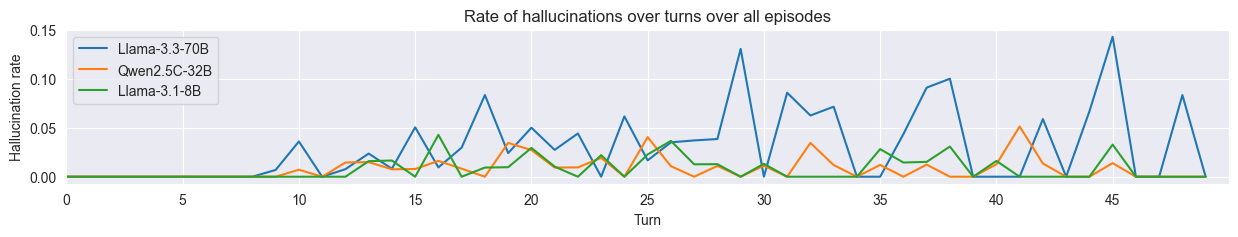

In [1204]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "hallucination"

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "hallucinations"

ax.set(xlabel='Turn', ylabel=f'Hallucination rate',
       title=f'Rate of {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

fig.savefig("results/top_models_hallucinations_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_hallucinations_all.png")

plt.show()

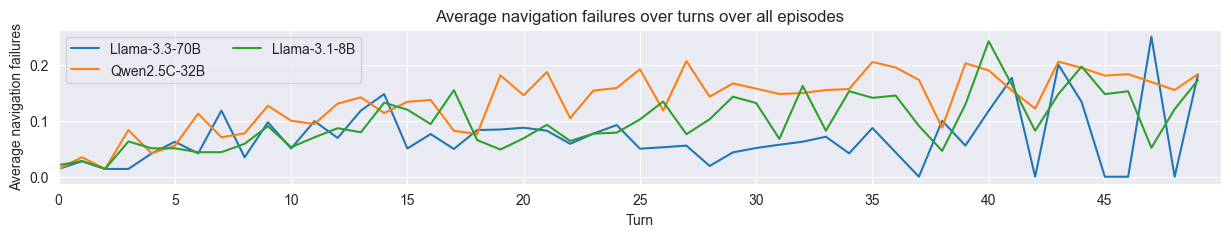

In [1205]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "no_exit_to"

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "navigation failures"

ax.set(xlabel='Turn', ylabel=f'Average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend(ncols=2)

fig.savefig("results/top_models_nav_fail_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_nav_fail_all.png")

plt.show()

In [1206]:
def get_min_turns_score(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    min_array = np.nanmin(progress_array, axis=0)

    return min_array

In [1207]:
def get_median_turns_score(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    median_array = np.nanmedian(progress_array, axis=0)

    return median_array

In [1208]:
def get_max_turns_score(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0, 16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    max_array = np.nanmax(progress_array, axis=0)

    return max_array

In [1209]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

# get_min_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "no_exit_to")

In [1210]:
# get_median_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "no_exit_to")

In [1211]:
# get_max_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "no_exit_to")

### Accumulative

In [1212]:
def get_score_progress_list_acc(model_id: str, variant: str, episode: str, score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    if 'round scores' in scores:
        turn_scores = scores['round scores']
    elif 'turn scores' in scores:
        turn_scores = scores['turn scores']
    turns_score = list()
    for turn_idx, turn_scores_value in enumerate(turn_scores.values()):
        if score in turn_scores_value:
            if turn_idx == 0:
                turns_score.append(turn_scores_value[score])
            else:
                turns_score.append(turns_score[turn_idx-1] + turn_scores_value[score])
        else:
            print(f"{score} not in turn {turn_idx} of {model_id} {variant} {episode}")
            turns_score.append(np.nan)

    return turns_score

In [1213]:
def get_avg_turns_score_acc(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list_acc(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)
    progress_array = np.array(list_of_arrays)
    averages_array = np.nanmean(progress_array, axis=0)

    return averages_array

In [1214]:
# get_score_progress_list("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", "1_home_deliver_three_planning_easy", "episode_0", "epistemic_action")

In [1215]:
# get_score_progress_list_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", "1_home_deliver_three_planning_easy", "episode_0", "epistemic_action")

In [1216]:
# variants = ["1_home_deliver_three_planning_easy", "3_home_deliver_three_planning_easy_invlimittwo",
#           "5_home_deliver_three_planning_hard", "7_home_deliver_three_planning_hard_invlimittwo"]

# variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
#            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
#            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

# variants = ["1_home_deliver_three_planning_easy"]

variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

# variants = ["0_home_deliver_three_basic_easy"]

# get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "epistemic_action")

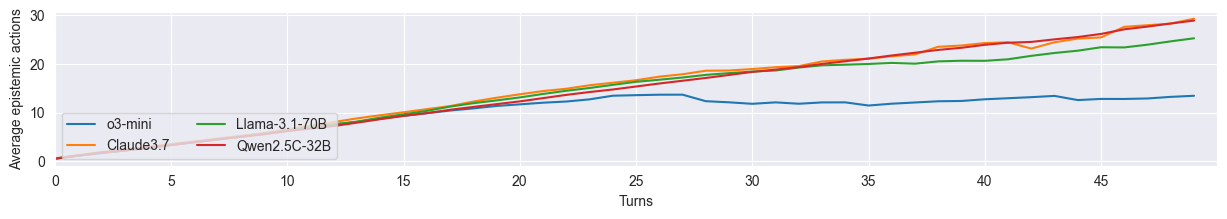

In [1217]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "epistemic_action"

ax.plot(get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score_acc("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score_acc("claude-3-7-sonnet-20250219-t0.0--claude-3-7-sonnet-20250219-t0.0", variants, metric), label="Claude3.7")
# ax.plot(get_avg_turns_score_acc("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score_acc("Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0", variants, metric), label="Llama-3.1-70B")
ax.plot(get_avg_turns_score_acc("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
# ax.plot(get_avg_turns_score_acc("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "epistemic actions"

ax.set(xlabel='Turns', ylabel=f'Average {metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

# plt.legend()
plt.legend(loc="lower left", ncols=2)

fig.savefig("results/top_models_epistemic_actions_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_epistemic_actions_all.png")

plt.show()

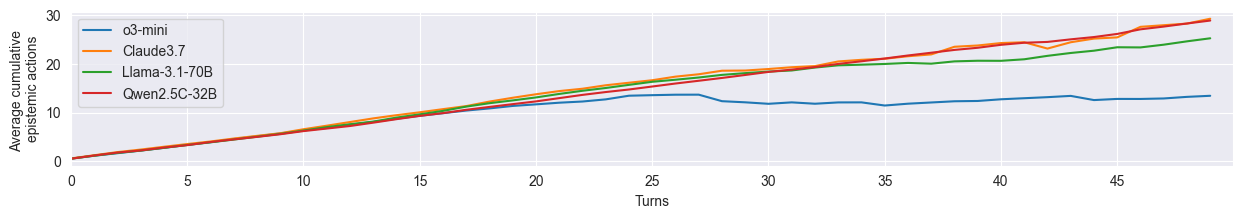

In [1218]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "epistemic_action"

ax.plot(get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score_acc("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score_acc("claude-3-7-sonnet-20250219-t0.0--claude-3-7-sonnet-20250219-t0.0", variants, metric), label="Claude3.7")
# ax.plot(get_avg_turns_score_acc("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score_acc("Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0", variants, metric), label="Llama-3.1-70B")
ax.plot(get_avg_turns_score_acc("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
# ax.plot(get_avg_turns_score_acc("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "cumulative \nepistemic actions"

ax.set(xlabel='Turns', ylabel=f'Average {metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

fig.savefig("results/top_models_cumulative_epistemic_actions_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_cumulative_epistemic_actions_all.png")

plt.show()

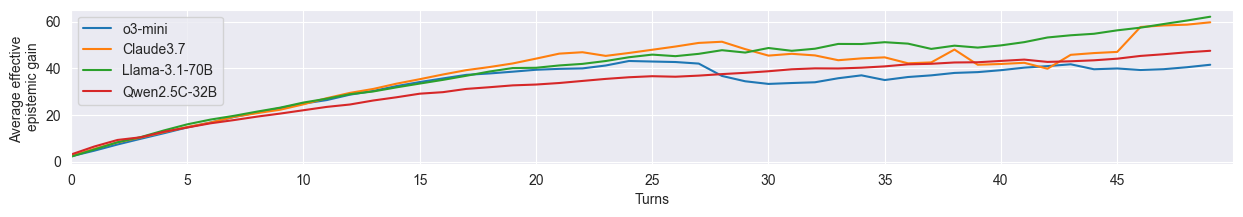

In [1219]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "effective_epistemic_gain_amount"

ax.plot(get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score_acc("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score_acc("claude-3-7-sonnet-20250219-t0.0--claude-3-7-sonnet-20250219-t0.0", variants, metric), label="Claude3.7")
# ax.plot(get_avg_turns_score_acc("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score_acc("Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0", variants, metric), label="Llama-3.1-70B")
ax.plot(get_avg_turns_score_acc("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
# ax.plot(get_avg_turns_score_acc("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "effective \nepistemic gain"

ax.set(xlabel='Turns', ylabel=f'Average {metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

plot_tag = "epistemic_gain"
fig.savefig(f"results/top_models_{plot_tag}_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig(f"results/top_models_{plot_tag}_all.png")

plt.show()

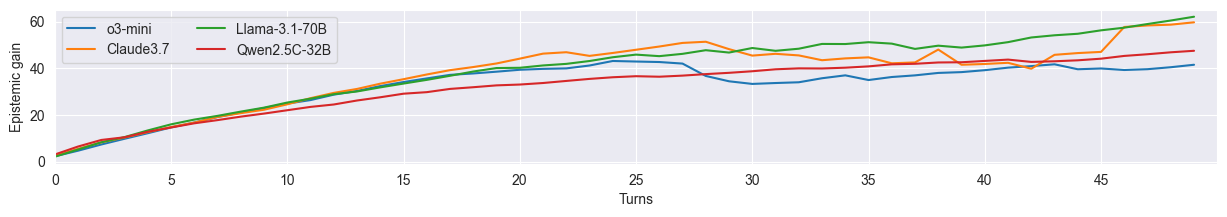

In [1220]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "effective_epistemic_gain_amount"

ax.plot(get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score_acc("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score_acc("claude-3-7-sonnet-20250219-t0.0--claude-3-7-sonnet-20250219-t0.0", variants, metric), label="Claude3.7")
# ax.plot(get_avg_turns_score_acc("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score_acc("Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0", variants, metric), label="Llama-3.1-70B")
ax.plot(get_avg_turns_score_acc("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
# ax.plot(get_avg_turns_score_acc("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "Epistemic gain"

ax.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend(ncols=2)

plot_tag = "cumulative_epistemic_gain"
fig.savefig(f"results/{plot_tag}.pdf", format="pdf", bbox_inches="tight")
fig.savefig(f"results/{plot_tag}.png")

plt.show()

#### Paired epistemic gain and known goal entities plots

In [1221]:
# plart =

known_goal_entities_ratio not in turn 22 of Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0 14_new-words_created_basic_hard episode_2
known_goal_entities_ratio not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 6_home_deliver_three_basic_hard episode_5
effective_epistemic_gain_amount not in turn 22 of Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0 14_new-words_created_basic_hard episode_2
effective_epistemic_gain_amount not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 6_home_deliver_three_basic_hard episode_5


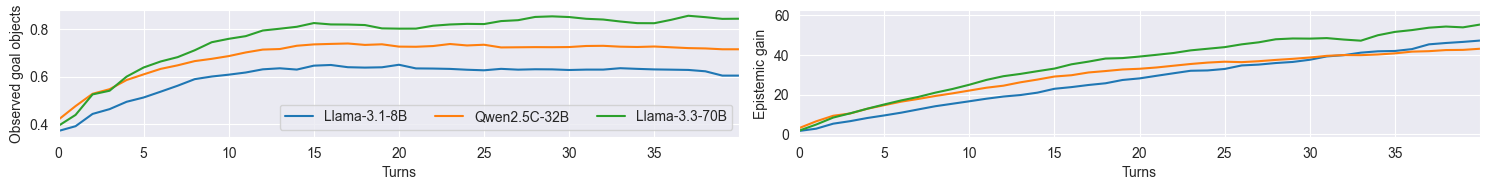

In [1222]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 2))



metric = "known_goal_entities_ratio"

ax1.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")
ax1.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax1.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
# ax1.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax1.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")

metric_name = "Observed goal objects"

ax1.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

xlim = 40
ax1.set_xlim([0,xlim])
ax1.set_xticks(np.arange(0, xlim, step=5))

ax1.legend(ncols=3)


metric = "effective_epistemic_gain_amount"

ax2.plot(get_avg_turns_score_acc("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")
ax2.plot(get_avg_turns_score_acc("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax2.plot(get_avg_turns_score_acc("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
# ax2.plot(get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax2.plot(get_avg_turns_score_acc("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")

metric_name = "Epistemic gain"

ax2.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
        )
# ax.grid()

xlim = 40
plt.xlim([0,xlim])
plt.xticks(np.arange(0, xlim, step=5))

plt.tight_layout()

fig.savefig("results/exploration_epistemic_paired.pdf", format="pdf", dpi=300, bbox_inches="tight")
# fig.savefig("results/top_models_known_goal_entities_ratio_all.png")

plt.show()

known_goal_entities_ratio not in turn 22 of Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0 14_new-words_created_basic_hard episode_2
known_goal_entities_ratio not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 6_home_deliver_three_basic_hard episode_5
effective_epistemic_gain_amount not in turn 22 of Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0 14_new-words_created_basic_hard episode_2
effective_epistemic_gain_amount not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 6_home_deliver_three_basic_hard episode_5


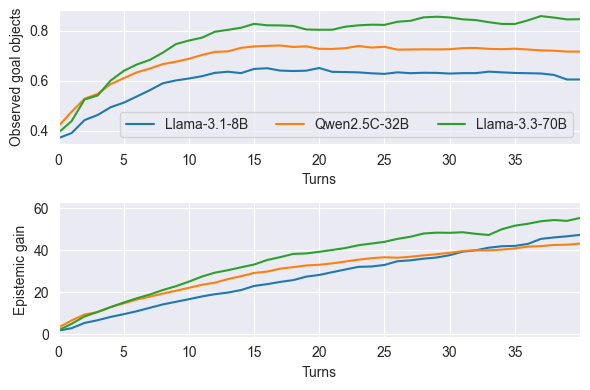

In [1223]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4))


metric = "known_goal_entities_ratio"

ax1.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")
ax1.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax1.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
# ax1.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax1.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")

metric_name = "Observed goal objects"

ax1.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

xlim = 40
ax1.set_xlim([0,xlim])
ax1.set_xticks(np.arange(0, xlim, step=5))

ax1.legend(ncols=3)


metric = "effective_epistemic_gain_amount"

ax2.plot(get_avg_turns_score_acc("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")
ax2.plot(get_avg_turns_score_acc("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax2.plot(get_avg_turns_score_acc("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
# ax2.plot(get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax2.plot(get_avg_turns_score_acc("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")

metric_name = "Epistemic gain"

ax2.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
        )
# ax.grid()

xlim = 40
plt.xlim([0,xlim])
plt.xticks(np.arange(0, xlim, step=5))

plt.tight_layout()

fig.savefig("results/exploration_epistemic_paired_vertical.pdf", format="pdf", dpi=300, bbox_inches="tight")
# fig.savefig("results/top_models_known_goal_entities_ratio_all.png")

plt.show()

#### Compound measures

In [1224]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

# avg_ep_acts = get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "epistemic_action")
# avg_ep_gain = get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "effective_epistemic_gain_amount")

In [1292]:
def get_epistemic_effect(model_id: str, variants: list):
    avg_ep_acts = get_avg_turns_score(model_id, variants, "epistemic_action")
    avg_ep_gain = get_avg_turns_score(model_id, variants, "effective_epistemic_gain_amount")

    ep_effect_compound = avg_ep_acts / avg_ep_gain

    return ep_effect_compound

In [1226]:
def get_epistemic_effect_progress_list(model_id: str, variant: str, episode: str):
    ep_acts = get_score_progress_list(model_id, variant, episode, "epistemic_action")
    print(ep_acts)
    ep_gain = get_score_progress_list(model_id, variant, episode, "effective_epistemic_gain_amount")
    print(ep_gain)

    epistemic_effect_progression = ep_acts * ep_gain

    return epistemic_effect_progression

In [1227]:
# get_epistemic_effect_progress_list("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", "0_home_deliver_three_basic_easy", "episode_0")

In [1228]:
def get_avg_turns_score(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    averages_array = np.nanmean(progress_array, axis=0)

    return averages_array

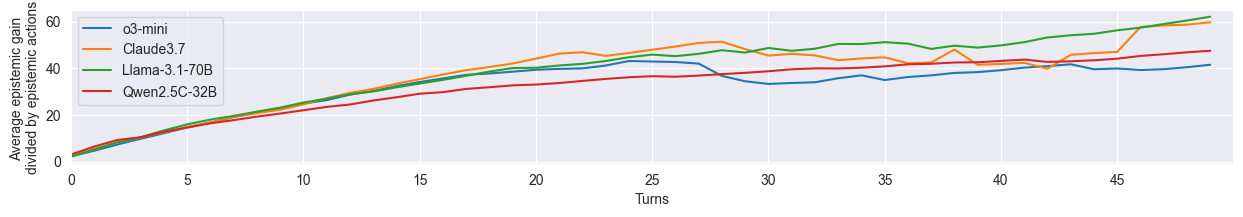

In [1229]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

ax.plot(get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score_acc("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score_acc("claude-3-7-sonnet-20250219-t0.0--claude-3-7-sonnet-20250219-t0.0", variants, metric), label="Claude3.7")
# ax.plot(get_avg_turns_score_acc("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score_acc("Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0", variants, metric), label="Llama-3.1-70B")
ax.plot(get_avg_turns_score_acc("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
# ax.plot(get_avg_turns_score_acc("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "epistemic gain \ndivided by epistemic actions"

ax.set(xlabel='Turns', ylabel=f'Average {metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

plot_tag = "epistemic_compound"
fig.savefig(f"results/top_models_{plot_tag}_all_.pdf", format="pdf", bbox_inches="tight")
fig.savefig(f"results/top_models_{plot_tag}_all_.png")

plt.show()

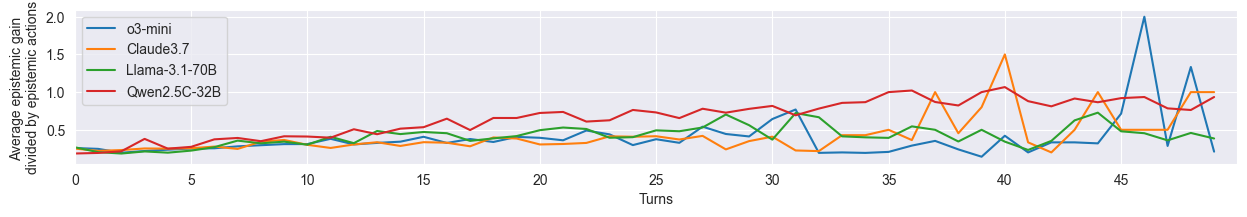

In [1293]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

ax.plot(get_epistemic_effect("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants), label="o3-mini")
# ax.plot(get_epistemic_effect("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants), label="Claude3.5")
ax.plot(get_epistemic_effect("claude-3-7-sonnet-20250219-t0.0--claude-3-7-sonnet-20250219-t0.0", variants), label="Claude3.7")
# ax.plot(get_epistemic_effect("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants), label="Llama-3.3-70B")
ax.plot(get_epistemic_effect("Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0", variants), label="Llama-3.1-70B")
ax.plot(get_epistemic_effect("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants), label="Qwen2.5C-32B")
# ax.plot(get_epistemic_effect("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants), label="Llama-3.1-8B")

metric_name = "epistemic gain \ndivided by epistemic actions"

ax.set(xlabel='Turns', ylabel=f'Average {metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

plot_tag = "epistemic_compound"
fig.savefig(f"results/top_models_{plot_tag}_all_1.pdf", format="pdf", bbox_inches="tight")
fig.savefig(f"results/top_models_{plot_tag}_all_1.png")

plt.show()

### old

In [1230]:
# get single episode for exploration line plot
# model_id = "openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0"
model_id = 'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0'
variant = "0_home_deliver_three_basic_easy"
# variant = "2_home_deliver_three_basic_easy_invlimittwo"
# episode = "episode_0"
episode = "episode_2"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
if 'round scores' in scores:
    turn_scores = scores['round scores']
elif 'turn scores' in scores:
    turn_scores = scores['turn scores']
turns_epistemic = [score_values['epistemic_action'] for score_values in turn_scores.values()]
turns_pragmatic = [score_values['pragmatic_action'] for score_values in turn_scores.values()]
turns_epistemic_gain = [score_values['effective_epistemic_gain_amount'] for score_values in turn_scores.values()]
turns_goal_score = [score_values['goal_score'] for score_values in turn_scores.values()]
turns_resolution_fail = [score_values['action_resolution_fail'] for score_values in turn_scores.values()]
turns_parsing_fail = [score_values['action_parsing_fail'] for score_values in turn_scores.values()]

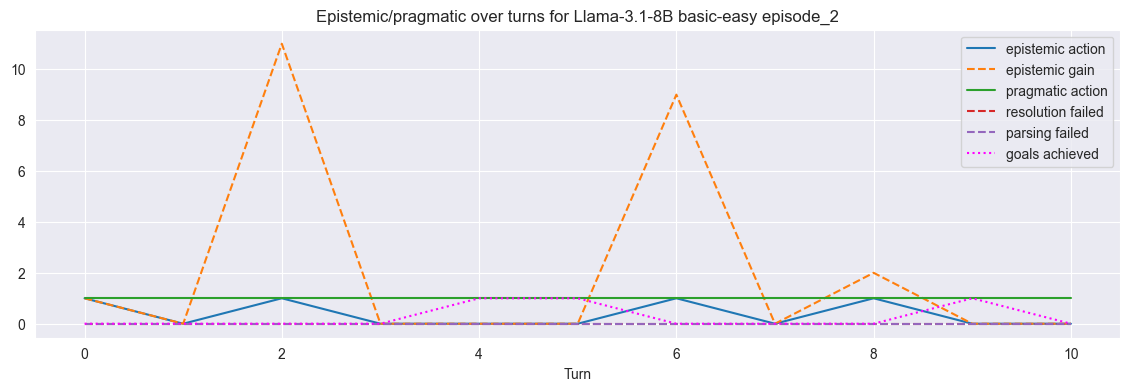

In [1231]:
fig, ax = plt.subplots(figsize=(14, 4))

# ax.plot(turns_known_entities_ratio)
ax.plot(turns_epistemic)
ax.plot(turns_epistemic_gain, linestyle='dashed')
ax.plot(turns_pragmatic)
ax.plot(turns_resolution_fail, linestyle='dashed')
ax.plot(turns_parsing_fail, linestyle='dashed')
ax.plot(turns_goal_score, linestyle='dotted', color='magenta')

ax.set(xlabel='Turn',
       title=f'Epistemic/pragmatic over turns for {model_name_dict[model_id]} {experiment_short_name_dict[variant]} {episode}')
# ax.grid()
ax.legend(['epistemic action', 'epistemic gain', 'pragmatic action', 'resolution failed', 'parsing failed', 'goals achieved'], loc='upper right')

# fig.savefig("test.png")
plt.show()

### Average turns and epistemic/pragmatic actions

In [1232]:
# get single episode for exploration line plot
# model_id = "openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0"
model_id = 'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0'
# variant = "0_home_deliver_three_basic_easy"
variant = "4_home_deliver_three_basic_easy_invlimittwo"
# episode = "episode_0"
episode = "episode_2"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)

In [1233]:
def get_score_over_episodes(model_id, variant, score):
    all_episodes = list()
    if os.path.exists(f"results/{model_id}"):
        for ep_num in range(0,16):
            episode = f"episode_{ep_num}"
            # print(variant, episode)
            episode_score_list = list()
            with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
                scores = json.load(scores_file)
                # print("scores:", scores)
                if 'round scores' in scores:
                    ep_turn_scores = scores['round scores']
                elif 'turn scores' in scores:
                    ep_turn_scores = scores['turn scores']
                for turn_number, turn_dict in ep_turn_scores.items():
                    # print("turn number:", turn_number)
                    # in some cases the score might be missing on the last turn:
                    if score in turn_dict:
                        episode_score_list.append(turn_dict[score])
                all_episodes.append(episode_score_list)
        return all_episodes
    else:
        return []


In [1234]:
epistemic_action_counts = get_score_over_episodes(model_id, variant, "epistemic_action")
epistemic_action_counts

[[1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0],
 [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0],
 [1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
 [1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0],
 [1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0],
 [1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1],
 [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0],
 [1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
 

In [1235]:
numbers_of_turns = [len(episode_turns) for episode_turns in epistemic_action_counts]
numbers_of_turns

[30, 22, 11, 28, 20, 50, 18, 27, 50, 50, 25, 21, 41, 26, 21, 50]

In [1236]:
numbers_of_epistemic_actions = [sum(episode_turns) for episode_turns in epistemic_action_counts]
numbers_of_epistemic_actions

[14, 12, 4, 16, 12, 25, 9, 10, 33, 32, 13, 10, 23, 10, 11, 33]

In [1237]:
average_number_of_turns = np.average(numbers_of_turns)
average_number_of_turns

30.625

In [1238]:
average_number_of_epistemic_actions = np.average(numbers_of_epistemic_actions)
average_number_of_epistemic_actions

16.6875

In [1239]:
def get_average_score_over_experiments(model_id, score):
    variant_turns_average = list()
    variant_score_averages = list()
    for variant in experiment_short_name_dict.keys():
        variant_scores = get_score_over_episodes(model_id, variant, score)
        numbers_of_turns = [len(episode_turns) for episode_turns in variant_scores]
        numbers_of_scores = [sum(episode_turns) for episode_turns in variant_scores]
        average_number_of_turns = np.average(numbers_of_turns)
        variant_turns_average.append(average_number_of_turns)
        average_number_of_scores = np.average(numbers_of_scores)
        variant_score_averages.append(average_number_of_scores)
    return variant_turns_average, variant_score_averages


In [1240]:
# get_average_score_over_experiments(model_id, "epistemic_action")

In [1241]:
get_average_score_over_experiments("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", "epistemic_action")

([15.5,
  13.25,
  20.5625,
  27.625,
  30.9375,
  29.6875,
  23.4375,
  41.6875,
  23.4375,
  21.0],
 [8.4375,
  6.0625,
  11.25,
  18.75,
  22.3125,
  18.375,
  14.3125,
  22.4375,
  8.6875,
  6.9375])

In [1242]:
# get averages for all models
def get_average_epistemic_all(model_names = None):
    avg_turns_list = list()
    avg_epistemic_gain_list = list()
    avg_epistemic_actions_list = list()
    avg_plan_viability_list = list()

    if not model_names:
        model_names = model_name_dict.keys()

    for model_id in model_names:
        print(model_id)
        avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "effective_epistemic_gain_amount")
        avg_turns = avg_epistemic_scores_tuple[0]
        # print("avg_turns", avg_turns)
        avg_turns_overall = np.average(avg_epistemic_scores_tuple[0])
        # print("avg_turns_overall", avg_turns_overall)
        if not np.isnan(avg_turns_overall):
            avg_turns_list.append(avg_turns_overall)
        avg_epistemic_gain = avg_epistemic_scores_tuple[1]
        avg_epistemic_gain_overall = np.average(avg_epistemic_scores_tuple[1])
        if not np.isnan(avg_epistemic_gain_overall):
            avg_epistemic_gain_list.append(avg_epistemic_gain_overall)
        avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "epistemic_action")
        avg_epistemic_actions = avg_epistemic_scores_tuple[1]
        avg_epistemic_actions_overall = np.average(avg_epistemic_scores_tuple[1])
        if not np.isnan(avg_epistemic_actions_overall):
            avg_epistemic_actions_list.append(avg_epistemic_actions_overall)
        avg_plan_viability_tuple = get_average_score_over_experiments(model_id, "plan_command_success_ratio")
        avg_plan_viability = avg_plan_viability_tuple[1]
        avg_plan_viability_overall = np.average(avg_plan_viability_tuple[1])
        if not np.isnan(avg_plan_viability_overall):
            avg_plan_viability_list.append(avg_plan_viability_overall)
    return avg_turns_list, avg_epistemic_gain_list, avg_epistemic_actions_list, avg_plan_viability_list

In [1243]:
# avg_turns_list, avg_epistemic_gain_list, avg_epistemic_actions_list, avg_plan_viability_list = get_average_epistemic_all(top_models)
# print(avg_turns_list)
# print(avg_epistemic_gain_list)
# print(avg_epistemic_actions_list)
# print(avg_plan_viability_list)

# Misc episode detection

In [1244]:
def get_turn_score_progressions(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    # list_of_arrays = list()
    progs_dict = dict()
    for variant in variants:
        progs_dict[variant] = dict()
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            # list_of_arrays.append(prog_array)
            progs_dict[variant][episode] = prog_array
    # progress_array = np.array(list_of_arrays)
    # averages_array = np.nanmean(progress_array, axis=0)

    return progs_dict

In [1245]:
def detect_best_earliest_score(prog_dict: dict, turn_offset_factor: float = 0.1):
    best_eps = list()
    best_score = 0
    best_earliest_eps = list()
    best_earliest_score = 0
    for variant, episodes in prog_dict.items():
        for ep_id, progression in episodes.items():
            for turn_idx in range(50):
                turn_score = progression[turn_idx]
                if turn_score > best_score:
                    best_ep = f"{variant} {ep_id} turn {turn_idx}"
                    best_eps.append(best_ep)
                    best_score = turn_score

                turn_lateness_offset = turn_idx * turn_offset_factor
                turn_offset_score = turn_score - turn_lateness_offset
                if turn_offset_score > best_earliest_score:
                    best_earliest_ep = f"{variant} {ep_id} turn {turn_idx}"
                    best_earliest_eps.append(best_earliest_ep)
                    best_earliest_score = turn_offset_score

    return best_eps, best_earliest_eps

In [1246]:
# detect_best_earliest_score(o3_plan_progs, turn_offset_factor=0.01)

In [1247]:
def detect_best_long_plan(prog_dict: dict, model_id: str):
    best_longest_eps = list()
    best_score = 0
    longest_plan = 0
    highest_go = 0
    for variant, episodes in prog_dict.items():
        for ep_id, progression in episodes.items():

            # load interactions:
            with open(f"results/{model_id}/adventuregame/{variant}/{ep_id}/interactions.json", 'r', encoding='utf-8') as interactions_file:
                ep_interactions = json.load(interactions_file)

            # for turn_idx, turn_acts in enumerate(ep_interactions['turns']):

            ep_plan_lengths = list()
            ep_plan_go_count = list()

            for turn_acts in ep_interactions['turns']:
                for turn_act in turn_acts:
                    if turn_act['action']['type'] == 'plan_length':
                        ep_plan_lengths.append(turn_act['action']['content'])
                    if turn_act['action']['type'] == 'current_plan':
                        go_count = 0
                        split_plan = turn_act['action']['content'][1:-1].replace("'", "").split(", ")
                        # for planned_action in turn_act['action']['content']:
                        for planned_action in split_plan:
                            # print(planned_action)
                            # "go" | "enter" | "return" | "proceed" | "move\
                            if planned_action.startswith(('go', 'move', 'enter', 'return', 'proceed')):
                                go_count += 1
                        ep_plan_go_count.append(go_count)

            # print(variant, ep_id, ep_plan_go_count)

            # print(ep_plan_lengths)

            for turn_idx in range(50):
                long = False
                more_go = False
                if turn_idx < len(ep_plan_lengths):
                    turn_score = progression[turn_idx]
                    if ep_plan_lengths[turn_idx] >= longest_plan:
                        long = True
                        longest_plan = ep_plan_lengths[turn_idx]

                    if ep_plan_go_count[turn_idx] > highest_go:
                        more_go = True
                        highest_go = ep_plan_go_count[turn_idx]

                    plan_turn_score = ep_plan_lengths[turn_idx] * turn_score

                    # if long and more_go and turn_score > best_score:
                    if plan_turn_score > best_score:
                        # if long and plan_turn_score > best_score:
                        best_ep = f"{variant} {ep_id} turn {turn_idx}"
                        best_longest_eps.append(best_ep)
                        # best_score = turn_score
                        best_score = plan_turn_score

    print(best_score, longest_plan)

    return best_longest_eps

In [1248]:
# detect_best_long_plan(o3_plan_progs, "o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0")

## Navigation

In [1249]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

# claude_nav_progs = get_turn_score_progressions('claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0', variants, "no_exit_to")

In [1250]:
def detect_nav_fail_correction(prog_dict: dict, model_id: str):
    corrected_eps = list()
    bad_eps = list()
    double_nav_fails = list()
    prime_examples = list()
    for variant, episodes in prog_dict.items():
        for ep_id, progression in episodes.items():
            single_fail = False
            single_fail_turn = int()

            nav_fail_sum = np.nansum(progression)
            if not 2 > nav_fail_sum > 0:
                single_fail = True

            if nav_fail_sum > 5:
                bad_eps.append(f"{variant} {ep_id}")

            for turn_idx in range(50):
                turn_score = progression[turn_idx]
                if turn_score == 1:
                    # check if next turn is a nav fail too
                    if turn_idx+1 < 50 and progression[turn_idx+1] == 1:
                        double_nav_fails.append(f"{variant} {ep_id}")
                    if single_fail:
                        single_fail_turn = turn_idx

            if not single_fail:
                continue

            # load interactions:
            with open(f"results/{model_id}/adventuregame/{variant}/{ep_id}/interactions.json", 'r', encoding='utf-8') as interactions_file:
                ep_interactions = json.load(interactions_file)

            correct_go_turns = list()

            for turn_idx, turn_acts in enumerate(ep_interactions['turns']):
                for turn_act in turn_acts:
                    if turn_act['action']['type'] == 'action_info':
                        act_content = turn_act['action']['content']
                        if act_content['action_type'] == "go":
                            correct_go_turns.append(turn_idx)

            for later_turn in range(single_fail_turn, len(ep_interactions['turns'])):
                cur_ep = f"{variant} {ep_id}"
                if later_turn in correct_go_turns and cur_ep not in corrected_eps:
                    corrected_eps.append(f"{variant} {ep_id}")

            if single_fail_turn+1 in correct_go_turns and single_fail_turn+2 in correct_go_turns and single_fail_turn+3 in correct_go_turns:
                prime_examples.append(f"{variant} {ep_id} turn {single_fail_turn}")



    return {'corrected': corrected_eps, 'bad': bad_eps, 'double_fails': double_nav_fails, 'prime_examples': prime_examples}

In [1251]:
# detect_nav_fail_correction(claude_nav_progs, 'claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0')

# Speed

In [1252]:
# get single episode for turn count

model_id = 'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0'
variant = "0_home_deliver_three_basic_easy"

episode = "episode_2"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
if 'round scores' in scores:
    turn_scores = scores['round scores']
elif 'turn scores' in scores:
    turn_scores = scores['turn scores']
len(turn_scores)

11

In [1253]:
def get_turn_values_model_experiment(model_id, experiment):
    episodes = [f"episode_{number}" for number in range(0,16)]
    model_experiment_turns: list = list()
    for episode in episodes:
        # get turn count:
        with open(f"results/{model_id}/adventuregame/{experiment}/{episode}/scores.json") as scores_file:
            scores = json.load(scores_file)
        if 'round scores' in scores:
            turn_scores = scores['round scores']
        elif 'turn scores' in scores:
            turn_scores = scores['turn scores']

        turns_taken = len(turn_scores)
        # get optimal turns:
        with open(f"results/{model_id}/adventuregame/{experiment}/{episode}/instance.json") as instance_file:
            instance = json.load(instance_file)
        optimal_turns = instance['optimal_turns']
        # dict and append:
        turns_dict: dict = {'turns_taken': turns_taken, 'optimal_turns': optimal_turns}
        model_experiment_turns.append(turns_dict)
    return model_experiment_turns

In [1254]:
def get_turn_values_model_experiment_ff(model_id, experiment):
    episodes = [f"episode_{number}" for number in range(0,5)]
    model_experiment_turns: list = list()
    for episode in episodes:
        # get turn count:
        with open(f"results/{model_id}/adventuregame/{experiment}/{episode}/scores.json") as scores_file:
            scores = json.load(scores_file)
        if 'round scores' in scores:
            turn_scores = scores['round scores']
        elif 'turn scores' in scores:
            turn_scores = scores['turn scores']

        turns_taken = len(turn_scores)
        # get optimal turns:
        with open(f"results/{model_id}/adventuregame/{experiment}/{episode}/instance.json") as instance_file:
            instance = json.load(instance_file)
        optimal_turns = instance['optimal_turns']
        # dict and append:
        turns_dict: dict = {'turns_taken': turns_taken, 'optimal_turns': optimal_turns}
        model_experiment_turns.append(turns_dict)
    return model_experiment_turns

In [1255]:
def get_turn_values_model_experiment_successful(model_id, experiment):
    """get turn values for successful episodes only"""
    episodes = [f"episode_{number}" for number in range(0,16)]
    model_experiment_turns: list = list()
    for episode in episodes:
        # get turn count:
        with open(f"results/{model_id}/adventuregame/{experiment}/{episode}/scores.json") as scores_file:
            scores = json.load(scores_file)
        if not scores["episode scores"]["Success"] == 1:
            continue

        if 'round scores' in scores:
            turn_scores = scores['round scores']
        elif 'turn scores' in scores:
            turn_scores = scores['turn scores']

        turns_taken = len(turn_scores)
        # get optimal turns:
        with open(f"results/{model_id}/adventuregame/{experiment}/{episode}/instance.json") as instance_file:
            instance = json.load(instance_file)
        optimal_turns = instance['optimal_turns']
        # dict and append:
        turns_dict: dict = {'turns_taken': turns_taken, 'optimal_turns': optimal_turns}
        model_experiment_turns.append(turns_dict)
    return model_experiment_turns

In [1256]:
model_id = 'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0'
experiment = "0_home_deliver_three_basic_easy"
get_turn_values_model_experiment(model_id, experiment)

[{'turns_taken': 18, 'optimal_turns': 10},
 {'turns_taken': 35, 'optimal_turns': 12},
 {'turns_taken': 11, 'optimal_turns': 8},
 {'turns_taken': 50, 'optimal_turns': 14},
 {'turns_taken': 13, 'optimal_turns': 11},
 {'turns_taken': 50, 'optimal_turns': 13},
 {'turns_taken': 19, 'optimal_turns': 10},
 {'turns_taken': 34, 'optimal_turns': 10},
 {'turns_taken': 50, 'optimal_turns': 11},
 {'turns_taken': 50, 'optimal_turns': 11},
 {'turns_taken': 17, 'optimal_turns': 10},
 {'turns_taken': 17, 'optimal_turns': 10},
 {'turns_taken': 50, 'optimal_turns': 10},
 {'turns_taken': 50, 'optimal_turns': 15},
 {'turns_taken': 17, 'optimal_turns': 14},
 {'turns_taken': 17, 'optimal_turns': 16}]

In [1257]:
# model_id = 'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0'
model_id = 'human-t0.0--human-t0.0'
experiment = "0_home_deliver_three_basic_easy"
get_turn_values_model_experiment_ff(model_id, experiment)

[{'turns_taken': 9, 'optimal_turns': 10},
 {'turns_taken': 11, 'optimal_turns': 12},
 {'turns_taken': 9, 'optimal_turns': 8},
 {'turns_taken': 13, 'optimal_turns': 14},
 {'turns_taken': 10, 'optimal_turns': 11}]

In [1258]:
def get_turn_values_experiment_all_models(experiment):
    all_models_experiment_turns: dict = dict()
    for model_id in final_models:
        all_models_experiment_turns[model_name_dict[model_id]] = get_turn_values_model_experiment(model_id, experiment)
    return all_models_experiment_turns

In [1259]:
def get_turn_values_experiment_all_models_ff(experiment):
    all_models_experiment_turns: dict = dict()
    for model_id in final_models:
        all_models_experiment_turns[model_name_dict[model_id]] = get_turn_values_model_experiment_ff(model_id, experiment)
    return all_models_experiment_turns

In [1260]:
# get_turn_values_experiment_all_models("0_home_deliver_three_basic_easy")

In [1261]:
get_turn_values_experiment_all_models_ff("0_home_deliver_three_basic_easy")

{'Claude-3.7': [{'turns_taken': 10, 'optimal_turns': 10},
  {'turns_taken': 17, 'optimal_turns': 12},
  {'turns_taken': 10, 'optimal_turns': 8},
  {'turns_taken': 18, 'optimal_turns': 14},
  {'turns_taken': 13, 'optimal_turns': 11}],
 'o3-mini': [{'turns_taken': 13, 'optimal_turns': 10},
  {'turns_taken': 15, 'optimal_turns': 12},
  {'turns_taken': 12, 'optimal_turns': 8},
  {'turns_taken': 50, 'optimal_turns': 14},
  {'turns_taken': 16, 'optimal_turns': 11}],
 'GPT-4o': [{'turns_taken': 10, 'optimal_turns': 10},
  {'turns_taken': 12, 'optimal_turns': 12},
  {'turns_taken': 10, 'optimal_turns': 8},
  {'turns_taken': 22, 'optimal_turns': 14},
  {'turns_taken': 13, 'optimal_turns': 11}],
 'Llama-3.1-70B': [{'turns_taken': 10, 'optimal_turns': 10},
  {'turns_taken': 17, 'optimal_turns': 12},
  {'turns_taken': 10, 'optimal_turns': 8},
  {'turns_taken': 18, 'optimal_turns': 14},
  {'turns_taken': 14, 'optimal_turns': 11}],
 'Llama-3.3-70B': [{'turns_taken': 10, 'optimal_turns': 10},
  {'tur

In [1262]:
experiments = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

def get_turn_values_all():
    all_turn_values: dict = dict()
    for experiment in experiments:
        all_turn_values[experiment_short_name_dict[experiment]] = get_turn_values_experiment_all_models(experiment)
    return all_turn_values

In [1263]:
def get_turn_values_all_ff():
    all_turn_values: dict = dict()
    for experiment in experiments:
        all_turn_values[experiment_short_name_dict[experiment]] = get_turn_values_experiment_all_models_ff(experiment)
    return all_turn_values

In [1264]:
all_turn_values_dict = get_turn_values_all()
# all_turn_values_dict

In [1265]:
all_turn_values_dict_ff = get_turn_values_all_ff()
all_turn_values_dict_ff

{'basic-easy': {'Claude-3.7': [{'turns_taken': 10, 'optimal_turns': 10},
   {'turns_taken': 17, 'optimal_turns': 12},
   {'turns_taken': 10, 'optimal_turns': 8},
   {'turns_taken': 18, 'optimal_turns': 14},
   {'turns_taken': 13, 'optimal_turns': 11}],
  'o3-mini': [{'turns_taken': 13, 'optimal_turns': 10},
   {'turns_taken': 15, 'optimal_turns': 12},
   {'turns_taken': 12, 'optimal_turns': 8},
   {'turns_taken': 50, 'optimal_turns': 14},
   {'turns_taken': 16, 'optimal_turns': 11}],
  'GPT-4o': [{'turns_taken': 10, 'optimal_turns': 10},
   {'turns_taken': 12, 'optimal_turns': 12},
   {'turns_taken': 10, 'optimal_turns': 8},
   {'turns_taken': 22, 'optimal_turns': 14},
   {'turns_taken': 13, 'optimal_turns': 11}],
  'Llama-3.1-70B': [{'turns_taken': 10, 'optimal_turns': 10},
   {'turns_taken': 17, 'optimal_turns': 12},
   {'turns_taken': 10, 'optimal_turns': 8},
   {'turns_taken': 18, 'optimal_turns': 14},
   {'turns_taken': 14, 'optimal_turns': 11}],
  'Llama-3.3-70B': [{'turns_taken'

In [1266]:
# get turns taken list -> min max, error bars etc

In [1267]:
def get_average_turns_taken(all_turn_values_dict):
    avg_dict: dict = dict()
    for exp, models in all_turn_values_dict.items():
        #print(exp, models)
        avg_dict[exp] = dict()
        for model, model_turns_list in models.items():
            # print(model_turns_list)
            turns_taken_list = [ep_turns['turns_taken'] for ep_turns in model_turns_list]
            # print(turns_taken_list)
            avg_turns = average(turns_taken_list)
            # print(avg_turns)
            avg_dict[exp][model] = avg_turns

            optimal_turns_list = [ep_turns['optimal_turns'] for ep_turns in model_turns_list]
            avg_optimal = average(optimal_turns_list)
            avg_dict[exp]['optimal'] = avg_optimal
            # break
        # break
    return avg_dict

In [1268]:
def get_average_turns_taken_ff(all_turn_values_dict_ff):
    avg_dict: dict = dict()
    for exp, models in all_turn_values_dict_ff.items():
        #print(exp, models)
        avg_dict[exp] = dict()
        for model, model_turns_list in models.items():
            # print(model_turns_list)
            turns_taken_list = [ep_turns['turns_taken'] for ep_turns in model_turns_list]
            # print(turns_taken_list)
            avg_turns = average(turns_taken_list)
            # print(avg_turns)
            avg_dict[exp][model] = avg_turns

            optimal_turns_list = [ep_turns['optimal_turns'] for ep_turns in model_turns_list]
            avg_optimal = average(optimal_turns_list)
            avg_dict[exp]['optimal'] = avg_optimal
            # break
        # break
    return avg_dict

In [1269]:
# get_average_turns_taken(all_turn_values_dict)

In [1270]:
get_average_turns_taken_ff(all_turn_values_dict_ff)

{'basic-easy': {'Claude-3.7': 13.6,
  'optimal': 11.0,
  'o3-mini': 21.2,
  'GPT-4o': 13.4,
  'Llama-3.1-70B': 13.8,
  'Llama-3.3-70B': 15.0,
  'DeepSeek-V3': 14.4,
  'Qwen2.5-32B': 16.6,
  'Qwen2-72B': 26.4,
  'Qwen2.5-72B': 27.0,
  'Llama-3.1-8B': 25.4},
 'basic-easy-preexp': {'Claude-3.7': 12.6,
  'optimal': 11.0,
  'o3-mini': 20.0,
  'GPT-4o': 13.4,
  'Llama-3.1-70B': 13.0,
  'Llama-3.3-70B': 13.6,
  'DeepSeek-V3': 12.6,
  'Qwen2.5-32B': 15.4,
  'Qwen2-72B': 13.0,
  'Qwen2.5-72B': 20.4,
  'Llama-3.1-8B': 16.8},
 'basic-easy-invlimit': {'Claude-3.7': 14.4,
  'optimal': 11.0,
  'o3-mini': 15.4,
  'GPT-4o': 12.8,
  'Llama-3.1-70B': 14.6,
  'Llama-3.3-70B': 19.4,
  'DeepSeek-V3': 14.0,
  'Qwen2.5-32B': 24.8,
  'Qwen2-72B': 20.4,
  'Qwen2.5-72B': 15.4,
  'Llama-3.1-8B': 22.2},
 'basic-hard': {'Claude-3.7': 25.6,
  'optimal': 18.8,
  'o3-mini': 28.4,
  'GPT-4o': 31.0,
  'Llama-3.1-70B': 23.8,
  'Llama-3.3-70B': 26.0,
  'DeepSeek-V3': 35.4,
  'Qwen2.5-32B': 43.2,
  'Qwen2-72B': 46.6,
  'Q

In [1271]:
"""
experiment_categories = {
    "basic": ["basic-easy", "basic-hard"],
    "preexplore": ["basic-easy-preexp", "basic-hard-preexp"],
    "invlimit": ["basic-easy-invlimit", "basic-hard-invlimit"],
    "new-words": ["new-words-easy", "new-words-medium", "new-words-hard"]
}
"""

experiment_categories = {
    "Basic": ["basic-easy", "basic-hard"],
    "Pre-exploration": ["basic-easy-preexp", "basic-hard-preexp"],
    "Inventory limit": ["basic-easy-invlimit", "basic-hard-invlimit"],
    "Synthetic words": ["new-words-easy", "new-words-medium", "new-words-hard"]
}

def get_average_turns_taken_grouped(all_turn_values_dict):
    avg_dict: dict = dict()
    for experiment_category in experiment_categories:
        # print(experiment_category)
        avg_dict[experiment_category] = dict()
        for exp, models in all_turn_values_dict.items():
            # print(exp, models)
            if exp not in experiment_categories[experiment_category]:
                # print(f"{exp} not in {experiment_categories[experiment_category]}")
                continue
            for model, model_turns_list in models.items():
                # print(model_turns_list)
                turns_taken_list = [ep_turns['turns_taken'] for ep_turns in model_turns_list]
                # print(turns_taken_list)
                avg_turns = average(turns_taken_list)
                # print(avg_turns)
                if model not in avg_dict[experiment_category]:
                    # avg_dict[experiment_category][model] = [avg_turns]
                    avg_dict[experiment_category][model] = turns_taken_list
                else:
                    # avg_dict[experiment_category][model].append(avg_turns)
                    avg_dict[experiment_category][model] += turns_taken_list

                optimal_turns_list = [ep_turns['optimal_turns'] for ep_turns in model_turns_list]
                avg_optimal = average(optimal_turns_list)
                avg_dict[experiment_category]['optimal'] = avg_optimal
                # break
            # break
        for model, turns_taken in avg_dict[experiment_category].items():
            # print(model, turns_taken)
            avg_dict[experiment_category][model] = average(turns_taken)

    return avg_dict

get_average_turns_taken_grouped(all_turn_values_dict)

{'Basic': {'Claude-3.7': 20.6875,
  'optimal': 19.1875,
  'o3-mini': 24.28125,
  'GPT-4o': 22.9375,
  'Llama-3.1-70B': 21.71875,
  'Llama-3.3-70B': 21.59375,
  'DeepSeek-V3': 23.3125,
  'Qwen2.5-32B': 33.03125,
  'Qwen2-72B': 38.9375,
  'Qwen2.5-72B': 39.53125,
  'Llama-3.1-8B': 38.46875},
 'Pre-exploration': {'Claude-3.7': 18.6875,
  'optimal': 19.1875,
  'o3-mini': 21.84375,
  'GPT-4o': 22.5625,
  'Llama-3.1-70B': 20.9375,
  'Llama-3.3-70B': 22.09375,
  'DeepSeek-V3': 26.125,
  'Qwen2.5-32B': 33.375,
  'Qwen2-72B': 29.21875,
  'Qwen2.5-72B': 31.84375,
  'Llama-3.1-8B': 30.34375},
 'Inventory limit': {'Claude-3.7': 20.59375,
  'optimal': 19.1875,
  'o3-mini': 21.78125,
  'GPT-4o': 25.15625,
  'Llama-3.1-70B': 24.40625,
  'Llama-3.3-70B': 25.125,
  'DeepSeek-V3': 27.875,
  'Qwen2.5-32B': 36.75,
  'Qwen2-72B': 32.3125,
  'Qwen2.5-72B': 33.65625,
  'Llama-3.1-8B': 37.4375},
 'Synthetic words': {'Claude-3.7': 22.854166666666668,
  'optimal': 6.0,
  'o3-mini': 31.395833333333332,
  'GPT-4o

In [1272]:
def get_average_turns_taken_grouped_ff(all_turn_values_dict_ff):
    avg_dict: dict = dict()
    for experiment_category in experiment_categories:
        # print(experiment_category)
        avg_dict[experiment_category] = dict()
        for exp, models in all_turn_values_dict_ff.items():
            # print(exp, models)
            if exp not in experiment_categories[experiment_category]:
                # print(f"{exp} not in {experiment_categories[experiment_category]}")
                continue
            for model, model_turns_list in models.items():
                # print(model_turns_list)
                turns_taken_list = [ep_turns['turns_taken'] for ep_turns in model_turns_list]
                # print(turns_taken_list)
                avg_turns = average(turns_taken_list)
                # print(avg_turns)
                if model not in avg_dict[experiment_category]:
                    # avg_dict[experiment_category][model] = [avg_turns]
                    avg_dict[experiment_category][model] = turns_taken_list
                else:
                    # avg_dict[experiment_category][model].append(avg_turns)
                    avg_dict[experiment_category][model] += turns_taken_list

                optimal_turns_list = [ep_turns['optimal_turns'] for ep_turns in model_turns_list]
                avg_optimal = average(optimal_turns_list)
                avg_dict[experiment_category]['optimal'] = avg_optimal
                # break
            # break
        for model, turns_taken in avg_dict[experiment_category].items():
            # print(model, turns_taken)
            avg_dict[experiment_category][model] = average(turns_taken)

    return avg_dict

get_average_turns_taken_grouped_ff(all_turn_values_dict_ff)

{'Basic': {'Claude-3.7': 19.6,
  'optimal': 18.8,
  'o3-mini': 24.8,
  'GPT-4o': 22.2,
  'Llama-3.1-70B': 18.8,
  'Llama-3.3-70B': 20.5,
  'DeepSeek-V3': 24.9,
  'Qwen2.5-32B': 29.9,
  'Qwen2-72B': 36.5,
  'Qwen2.5-72B': 35.2,
  'Llama-3.1-8B': 37.7},
 'Pre-exploration': {'Claude-3.7': 16.1,
  'optimal': 18.8,
  'o3-mini': 20.3,
  'GPT-4o': 22.1,
  'Llama-3.1-70B': 19.5,
  'Llama-3.3-70B': 20.8,
  'DeepSeek-V3': 29.2,
  'Qwen2.5-32B': 27.9,
  'Qwen2-72B': 27.7,
  'Qwen2.5-72B': 26.0,
  'Llama-3.1-8B': 28.3},
 'Inventory limit': {'Claude-3.7': 19.2,
  'optimal': 18.8,
  'o3-mini': 20.0,
  'GPT-4o': 22.0,
  'Llama-3.1-70B': 20.5,
  'Llama-3.3-70B': 22.1,
  'DeepSeek-V3': 27.5,
  'Qwen2.5-32B': 33.4,
  'Qwen2-72B': 30.4,
  'Qwen2.5-72B': 28.4,
  'Llama-3.1-8B': 29.3},
 'Synthetic words': {'Claude-3.7': 23.133333333333333,
  'optimal': 6.0,
  'o3-mini': 31.266666666666666,
  'GPT-4o': 26.133333333333333,
  'Llama-3.1-70B': 27.133333333333333,
  'Llama-3.3-70B': 28.333333333333332,
  'DeepS

In [1273]:
# speed_df = pd.DataFrame.from_dict(get_average_turns_taken(all_turn_values_dict), orient='index')
# speed_df = pd.DataFrame.from_dict(get_average_turns_taken(all_turn_values_dict))
speed_df = pd.DataFrame.from_dict(get_average_turns_taken_grouped(all_turn_values_dict))
# speed_df_no_opt = speed_df.drop('optimal')
speed_df_no_opt = speed_df.drop('optimal').rename({
    "Llama-3.1-70B": "LM3.1-70B",
    "Llama-3.1-8B": "LM3.1-8B",
    "Llama-3.3-70B": "LM3.3-70B",
    "Claude-3.7": "Cl",
    "DeepSeek-V3": "DS",
    "Qwen2.5-32B": "Q2.5-32B",
    "Qwen2.5-72B": "Q2.5-72B",
    "Qwen2-72B": "Q2-72B"
})
# speed_df
speed_df_no_opt

,Basic,Pre-exploration,Inventory limit,Synthetic words
Cl,20.68750,18.68750,20.59375,22.854167
o3-mini,24.28125,21.84375,21.78125,31.395833
GPT-4o,22.93750,22.56250,25.15625,23.250000
LM3.1-70B,21.71875,20.93750,24.40625,30.041667
LM3.3-70B,21.59375,22.09375,25.12500,29.520833
DS,23.31250,26.12500,27.87500,22.833333
Q2.5-32B,33.03125,33.37500,36.75000,41.250000
Q2-72B,38.93750,29.21875,32.31250,34.979167
Q2.5-72B,39.53125,31.84375,33.65625,36.708333
LM3.1-8B,38.46875,30.34375,37.43750,28.333333


In [1274]:
speed_df_ff = pd.DataFrame.from_dict(get_average_turns_taken_grouped_ff(all_turn_values_dict_ff))
# speed_df_no_opt = speed_df.drop('optimal')
speed_df_no_opt_ff = speed_df_ff.drop('optimal').rename({
    "Llama-3.1-70B": "LM3.1-70B",
    "Llama-3.1-8B": "LM3.1-8B",
    "Llama-3.3-70B": "LM3.3-70B",
    "Claude-3.7": "Cl",
    "DeepSeek-V3": "DS",
    "Qwen2.5-32B": "Q2.5-32B",
    "Qwen2.5-72B": "Q2.5-72B",
    "Qwen2-72B": "Q2-72B"
})
# speed_df
speed_df_no_opt_ff

,Basic,Pre-exploration,Inventory limit,Synthetic words
Cl,19.6,16.1,19.2,23.133333
o3-mini,24.8,20.3,20.0,31.266667
GPT-4o,22.2,22.1,22.0,26.133333
LM3.1-70B,18.8,19.5,20.5,27.133333
LM3.3-70B,20.5,20.8,22.1,28.333333
DS,24.9,29.2,27.5,21.066667
Q2.5-32B,29.9,27.9,33.4,42.200000
Q2-72B,36.5,27.7,30.4,33.400000
Q2.5-72B,35.2,26.0,28.4,38.200000
LM3.1-8B,37.7,28.3,29.3,23.800000


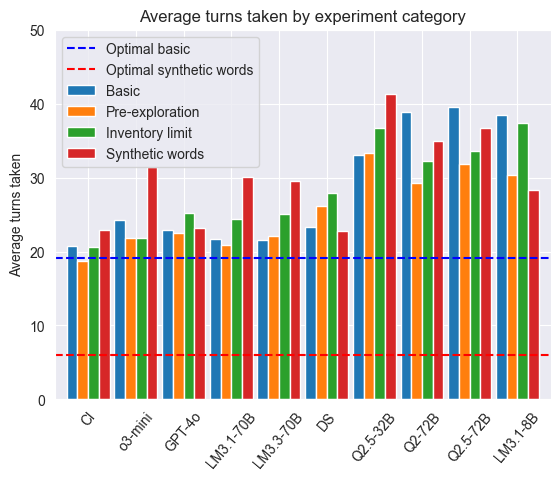

In [1275]:
# ax = speed_df[['Claude-3.7', 'o3-mini', 'GPT-4o', 'Llama-3.1-70B', 'Llama-3.3-70B', 'Llama-3.1-8B', 'DeepSeek-V3', 'Qwen2-72B', 'Qwen2.5-32B', 'Qwen2.5-72B']].plot.bar(figsize=(14, 4), width=0.9)
# ax = speed_df_no_opt.plot.bar(figsize=(14, 4), width=0.7)
ax = speed_df_no_opt.plot.bar(width=0.9)
# speed_df['optimal'].plot.line(ax=ax)
ax.set_ylabel("Average turns taken")
# ax.plot(19.1875)

plt.axhline(y=19.1875, color='blue', linestyle="--", label="Optimal basic")
plt.axhline(y=6.0, color='red', linestyle="--", label="Optimal synthetic words")

# plt.legend(loc='upper left', ncols=2)
plt.legend(loc='upper left')
# plt.legend(loc='upper left', nrows=3)
plt.ylim(0, 50)

# plt.xticks(rotation=0)
plt.xticks(rotation=50)

plt.title("Average turns taken by experiment category")
# plt.ylabel = "Turns taken"

plt.savefig("results/speed_plot_all.pdf", format="pdf", bbox_inches="tight")

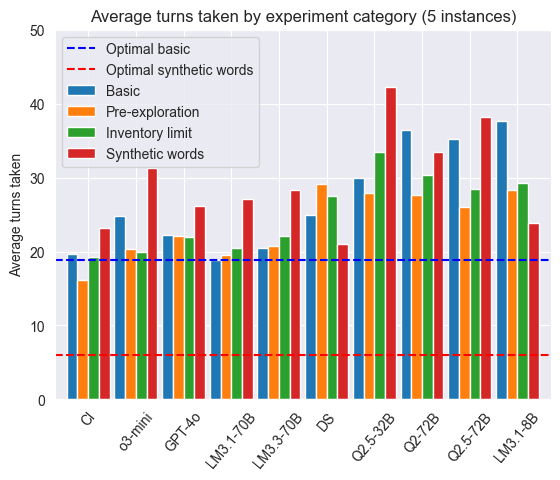

In [1276]:
ax = speed_df_no_opt_ff.plot.bar(width=0.9)
# speed_df['optimal'].plot.line(ax=ax)
ax.set_ylabel("Average turns taken")
# ax.plot(19.1875)

plt.axhline(y=18.8, color='blue', linestyle="--", label="Optimal basic")
plt.axhline(y=6.0, color='red', linestyle="--", label="Optimal synthetic words")

# plt.legend(loc='upper left', ncols=2)
plt.legend(loc='upper left')
# plt.legend(loc='upper left', nrows=3)
plt.ylim(0, 50)

# plt.xticks(rotation=0)
plt.xticks(rotation=50)

plt.title("Average turns taken by experiment category (5 instances)")
# plt.ylabel = "Turns taken"

plt.savefig("results/speed_plot_all_ff.pdf", format="pdf", bbox_inches="tight")

In [1277]:
speed_df_only_best = speed_df_no_opt.drop(['Q2.5-32B', 'Q2-72B', 'Q2.5-72B', 'LM3.1-8B']).rename({'LM3.1-70B': 'LM3.1', 'LM3.3-70B': 'LM3.3'})

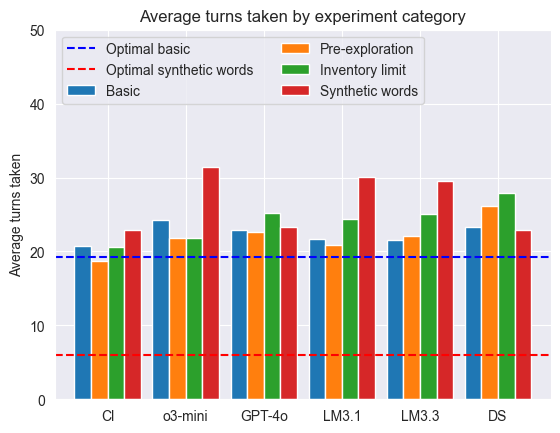

In [1278]:
ax = speed_df_only_best.plot.bar(width=0.85)
# speed_df['optimal'].plot.line(ax=ax)
ax.set_ylabel("Average turns taken")
# ax.plot(19.1875)

plt.axhline(y=19.1875, color='blue', linestyle="--", label="Optimal basic")
plt.axhline(y=6.0, color='red', linestyle="--", label="Optimal synthetic words")

plt.legend(loc='upper left', ncols=2)
# plt.legend(loc='upper left')
# plt.legend(loc='upper left', nrows=3)
plt.ylim(0, 50)

plt.xticks(rotation=0)
# plt.xticks(rotation=50)

plt.title("Average turns taken by experiment category")
# plt.ylabel = "Turns taken"

plt.savefig("results/speed_plot_selected.pdf", format="pdf", bbox_inches="tight")

# Human data

In [1279]:
game_human_df = raw_df[raw_df.game == 'adventuregame']
game_human_df = game_human_df.replace(model_name_dict).replace(experiment_short_name_dict)
# game_human_df = game_human_df.drop(game_human_df['episode'] in ['episode_5','episode_6','episode_7','episode_8','episode_9','episode_10','episode_11','episode_12','episode_13','episode_14','episode_15'])
# game_human_df = game_human_df[game_human_df.episode not in ['episode_5','episode_6','episode_7','episode_8','episode_9','episode_10','episode_11','episode_12','episode_13','episode_14','episode_15']]
game_human_df = game_human_df.query("episode not in ['episode_5','episode_6','episode_7','episode_8','episode_9','episode_10','episode_11','episode_12','episode_13','episode_14','episode_15']")
game_human_df = game_human_df.query('experiment in ["basic-easy", "basic-easy-preexp", "basic-easy-invlimit", "basic-hard", "basic-hard-preexp", "basic-hard-invlimit", "new-words-easy", "new-words-medium", "new-words-hard"]')
game_human_df

,game,model,experiment,episode,metric,value
0,adventuregame,Claude-3.7,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Claude-3.7,basic-easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Claude-3.7,basic-easy,episode_0,Request Count,10.0
3,adventuregame,Claude-3.7,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Claude-3.7,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
69116,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_0,Played,0.0
69117,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_1,Played,1.0
69124,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_2,Played,0.0
69125,adventuregame,Qwen2.5-32B,basic-hard-preexp,episode_3,Played,1.0


In [1280]:
from clemcore.clemeval import save_clem_table
TABLE_NAME = 'human_results'

save_clem_table(game_human_df, "results")


 Saved results into results/results.csv and .html


In [1281]:
# read the clem scores
RESULTS_PATH = Path('results/results_human.csv')
clem_human_df = pd.read_csv(RESULTS_PATH, index_col=0)

In [1282]:
clem_human_df = clem_human_df.rename(model_name_dict)
clem_human_df

,"-, clemscore","adventuregame, % Played","adventuregame, Quality Score","adventuregame, Quality Score (std)","all, Average % Played","all, Average Quality Score"
Claude-3.7,97.78,100.00,97.78,14.91,100.00,97.78
DeepSeek-V3,40.20,82.22,48.89,50.55,82.22,48.89
GPT-4o,51.36,88.89,57.78,49.95,88.89,57.78
Llama-3.1-70B,50.96,95.56,53.33,50.45,95.56,53.33
Llama-3.1-8B,11.26,42.22,26.67,44.72,42.22,26.67
Llama-3.3-70B,45.63,93.33,48.89,50.55,93.33,48.89
Qwen2-72B,26.27,62.22,42.22,49.95,62.22,42.22
Qwen2.5-32B,14.22,53.33,26.67,44.72,53.33,26.67
Qwen2.5-72B,17.28,55.56,31.11,46.82,55.56,31.11
human,100.00,100.00,100.00,0.00,100.00,100.00


In [1283]:
overview_df = clem_human_df.rename(model_name_dict).drop(columns=["all, Average % Played", "all, Average Quality Score", "adventuregame, Quality Score (std)"]).sort_values(by='-, clemscore', ascending=False)
overview_short_columns = {"-, clemscore": "clemscore", "adventuregame, % Played": "% Played", "adventuregame, Quality Score": "Quality Score", "adventuregame, Quality Score (std)": "Quality Score (std)"}
overview_df = overview_df.rename(columns=overview_short_columns)
overview_df

,clemscore,% Played,Quality Score
human,100.00,100.00,100.00
Claude-3.7,97.78,100.00,97.78
o3-mini,73.18,86.67,84.44
GPT-4o,51.36,88.89,57.78
Llama-3.1-70B,50.96,95.56,53.33
Llama-3.3-70B,45.63,93.33,48.89
DeepSeek-V3,40.20,82.22,48.89
Qwen2-72B,26.27,62.22,42.22
Qwen2.5-72B,17.28,55.56,31.11
Qwen2.5-32B,14.22,53.33,26.67


In [1284]:
# get overall goal%:
goals_df = game_human_df.drop(columns=["game"])
# goals_df = goals_df.query('metric in ["Main Score", "Played", "achieved_goal_rating"]')
goals_df = goals_df.query('metric in ["achieved_goal_rating"]')

# goals_df = goals_df.query("model in ['o3-mini', 'Claude-3.5', 'Llama-3.1-70B', 'Qwen2.5-32B', 'GPT-4o']")

# goals_df = build_dispersion_table(['model', 'experiment', 'metric'], goals_df)
goals_df = build_dispersion_table(['model', 'metric'], goals_df)
# goals_df = build_dispersion_table(['model'], goals_df)

goals_df = goals_df.drop(columns=["var", "median", "max", "min", "skew", "std"])

goals_df = goals_df.rename({"achieved_goal_rating": "% Goals"})

goals_df = pd.pivot_table(goals_df, index=['model'], columns='metric')

# goals_df = goals_df.rename({'mean': '% Goals'})

goals_df[('metric', '% Goals')] = goals_df[('mean', '% Goals')]

goals_df = goals_df.drop(columns=[('mean', '% Goals')])

goals_df

,metric
metric,% Goals
model,
Claude-3.7,99.259259
DeepSeek-V3,66.666667
GPT-4o,78.518519
Llama-3.1-70B,75.555556
Llama-3.1-8B,43.703704
Llama-3.3-70B,71.111111
Qwen2-72B,54.814815
Qwen2.5-32B,50.370370


In [1285]:
# combined_df = pd.concat([overview_df, goals_col.rename("% Goals")], axis=1)
# combined_df = pd.concat([overview_df, goals_col], axis=1)
combined_df = pd.concat([overview_df, goals_df], axis=1)
combined_df = combined_df.rename({'mean': '% Goals'})
combined_df

,clemscore,% Played,Quality Score,"(metric, % Goals)"
human,100.00,100.00,100.00,100.000000
Claude-3.7,97.78,100.00,97.78,99.259259
o3-mini,73.18,86.67,84.44,91.851852
GPT-4o,51.36,88.89,57.78,78.518519
Llama-3.1-70B,50.96,95.56,53.33,75.555556
Llama-3.3-70B,45.63,93.33,48.89,71.111111
DeepSeek-V3,40.20,82.22,48.89,66.666667
Qwen2-72B,26.27,62.22,42.22,54.814815
Qwen2.5-72B,17.28,55.56,31.11,55.555556
Qwen2.5-32B,14.22,53.33,26.67,50.370370


In [1286]:
combined_df.to_html("results/adventuregame_overview_table_goals_human.html")

In [1287]:
combined_overview_styled = combined_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
    # ], overwrite=False).format(subset="clemscore", precision=1).format(subset="% Played", precision=1).format(subset="Quality Score", precision=1).format(subset="('metric', '% Goals')", precision=1)
], overwrite=False).format(precision=1)
combined_overview_styled.to_latex('results/adventuregame_overview_table_goals_human.tex')

In [1288]:
top_stats_df = game_human_df.drop(columns=["game"])
# top_stats_df = top_stats_df.query('metric in ["Main Score", "Played", "Success", "hallucination_count"]')
# top_stats_df = top_stats_df.query('metric in ["Main Score", "Played", "achieved_goal_rating"]')
# top_stats_df = top_stats_df.query('metric in ["Main Score", "Played", "achieved_goal_rating", "plan_average_viability_ratio", "hallucination_count"]')
top_stats_df = top_stats_df.query('metric in ["Main Score", "Played", "achieved_goal_rating", "hallucination_count"]')
top_stats_df = top_stats_df.query(
    "model in ['human', 'o3-mini', 'Claude-3.7', 'Llama-3.1-70B', 'Qwen2.5-32B', 'GPT-4o', 'Llama-3.1-8B', 'Qwen2.5-72B', 'Qwen2-72B', 'Llama-3.3-70B', 'DeepSeek-V3']")

# top_stats_df = top_stats_df.query("experiment in ['basic-easy', 'basic-easy-invlimit', 'basic-easy-preexplore', 'basic-hard', 'basic-hard-invlimit', 'basic-hard-preexplore', 'new-words-easy', 'new-words-medium', 'new-words-hard']")
top_stats_df = top_stats_df.query(
    "experiment in ['basic-easy', 'basic-hard', 'basic-easy-preexp', 'basic-hard-preexp', 'basic-easy-invlimit', 'basic-hard-invlimit', 'new-words-easy', 'new-words-medium', 'new-words-hard']")

top_stats_df = build_dispersion_table(['model', 'experiment', 'metric'], top_stats_df)
top_stats_df = top_stats_df.drop(columns=["var", "median", "max", "min", "skew", "std"])
top_stats_df = top_stats_df.rename(metric_name_dict)
top_stats_df = top_stats_df.rename({"Main Score": "Quality"})
top_stats_df = top_stats_df.rename({"Played": "% Played"})
# top_stats_df = top_stats_df.rename({"Success": "% Success"})
top_stats_df = top_stats_df.rename({"hallucination_count": "% Hal."})
top_stats_df = top_stats_df.rename({"achieved_goal_rating": "% Goals"})
# top_stats_df = top_stats_df.rename({"plan_average_viability_ratio": "Plan Viability"})
top_stats_df = top_stats_df.reset_index()
top_stats_df = pd.pivot_table(top_stats_df, index=['model', 'experiment'], columns='metric')
top_stats_df[('metric', 'clemscore')] = top_stats_df[('mean', '% Played')] * top_stats_df[('mean', 'Quality')]
top_stats_df[('metric', 'Quality')] = top_stats_df[('mean', 'Quality')]
top_stats_df[('metric', '% Played')] = top_stats_df[('mean', '% Played')] * 100
top_stats_df[('metric', "% Lose")] = top_stats_df[('mean', "% Hal.")] * 100
top_stats_df[('metric', 'Goal Rate')] = top_stats_df[('mean', '% Goals')]
# top_stats_df[('metric', 'Plan Viability')] = top_stats_df[('mean', 'Plan Viability')] * 100
# top_stats_df[('metric', '% Success')] = top_stats_df[('mean', '% Success')] * 100
# top_stats_df = top_stats_df.drop(columns=[("mean", '% Played'), ("mean", '% Success'), ("mean", 'Quality'), ('mean', "% Hal.")])
# top_stats_df = top_stats_df.drop(columns=[("mean", '% Played'), ("mean", 'Quality'), ('mean', '% Goals'), ('mean', 'Plan Viability'), ('mean', "% Hal.")])
top_stats_df = top_stats_df.drop(
    columns=[("mean", '% Played'), ("mean", 'Quality'), ('mean', '% Goals'), ('mean', "% Hal.")])
top_stats_df


metric                                    
metric                         clemscore Quality % Played % Lose   Goal Rate
model      experiment                                                       
Claude-3.7 basic-easy              100.0   100.0    100.0    0.0  100.000000
           basic-easy-invlimit     100.0   100.0    100.0    0.0  100.000000
           basic-easy-preexp       100.0   100.0    100.0    0.0  100.000000
           basic-hard               80.0    80.0    100.0   20.0   93.333333
           basic-hard-invlimit     100.0   100.0    100.0    0.0  100.000000
...                                  ...     ...      ...    ...         ...
o3-mini    basic-hard-invlimit     100.0   100.0    100.0    0.0  100.000000
           basic-hard-preexp       100.0   100.0    100.0    0.0  100.000000
           new-words-easy           80.0    80.0    100.0   20.0   93.333333
           new-words-hard          100.0   100.0    100.0    0.0  100.000000
           new-words-medium          4.0    20.0     20.0    0.0   46.666667

[99 rows x 5 columns]

In [1289]:
top_stats_df.to_html("results/human_model_experiment_stats.html")